In [1]:
import os
import sys
from datetime import datetime, timedelta
import logging
import pickle
import time
from dataclasses import dataclass, field
from enum import Enum
from typing import Any, Dict, List, Optional, Set, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import unicodedata
from dotenv import load_dotenv

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify sys.path
print("Current sys.path:", sys.path)

# Local imports
from src.data_processing.game_utils import display_boxscore, get_game_boxscore
from src.data_processing.nst_scraper import nst_on_ice_scraper, nst_team_on_ice_scraper
from src.data_processing.pbp_utils import get_matchup_games
from src.data_processing.team_utils import get_fullname_by_tricode, get_most_recent_game_id
from src.db.nhl_db_utils import (
    append_player_ids,
    check_last_update,
    get_player_full_name,
    update_player_db,
)
from src.db.the_odds_db_utils import *
from src.entities.lineup import Lineup, Player, Position
from src.data_processing.wager_utils import american_to_decimal

# Configure pandas and numpy display options
pd.set_option('display.max_columns', None)
np.set_printoptions(legacy='1.21')


Current sys.path: ['C:\\Users\\H-100\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\H-100\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\H-100\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\H-100\\AppData\\Local\\Programs\\Python\\Python310', 'c:\\Users\\H-100\\Desktop\\python\\accurateshothelper\\.venv', '', 'c:\\Users\\H-100\\Desktop\\python\\accurateshothelper\\.venv\\lib\\site-packages', 'c:\\Users\\H-100\\Desktop\\python\\accurateshothelper\\.venv\\lib\\site-packages\\win32', 'c:\\Users\\H-100\\Desktop\\python\\accurateshothelper\\.venv\\lib\\site-packages\\win32\\lib', 'c:\\Users\\H-100\\Desktop\\python\\accurateshothelper\\.venv\\lib\\site-packages\\Pythonwin', 'c:\\Users\\H-100\\Desktop\\python\\accurateshothelper']


c:\Users\H-100\Desktop\python\accurateshothelper\.venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
today_datetime= datetime.now()
yesterday_datetime = today_datetime - timedelta(days=1, hours=6) # UTC offset
yesterday = yesterday_datetime.strftime('%Y-%m-%d')
yesterday

'2025-01-15'

In [3]:
# Load environment variables from .env file
load_dotenv()

db_prefix = 'NHL_DB_'

# Check the last update time of the players database
last_update = check_last_update(db_prefix)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Last database update was on: 2025-01-15
INFO:src.db.base_utils:Database connection closed.


In [4]:
# Convert last_update to datetime
last_update_dt = datetime.strptime(last_update, '%Y-%m-%d')
today_dt = datetime.strptime(today_datetime.strftime('%Y-%m-%d'), '%Y-%m-%d')
yesterday_dt = datetime.strptime(yesterday, '%Y-%m-%d')

# Only update if last update was before yesterday
if last_update_dt not in [today_dt, yesterday_dt]:
    # Update the player database from last update to yesterday
    update_player_db(last_update, yesterday, db_prefix, skip_existing=True)
else:
    print(f"No need to update the player database. Last update was on: {last_update}")


No need to update the player database. Last update was on: 2025-01-15


In [5]:
def add_player_to_lineup(lineup: Lineup, player: Player, category: str):
    """
    Adds a player to the lineup in the specified category, handling potential errors.
    
    Args:
        lineup (Lineup): The lineup object.
        player (Player): The player to add.
        category (str): The category ('forwards', 'defense', 'goalies').
    """
    try:
        if category == 'forwards':
            slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
            lineup.add_forward(player, slot)
        elif category == 'defense':
            slot = next(i for i, p in enumerate(lineup.defense) if p is None)
            lineup.add_defense(player, slot)
        elif category == 'goalies':
            slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, slot)
        else:
            print(f"Unknown category '{category}'.")
    except StopIteration:
        print(f"No available slots to add player '{player.name}' in category '{category}'.")
    except ValueError as ve:
        print(ve)
    except IndexError as ie:
        print(ie)

In [6]:
def get_skater_stats(lineup: Lineup, player_stats_df: pd.DataFrame, filter: Optional[str] = None) -> pd.DataFrame:
    """
    Gets stats for players in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing players
        player_stats_df (pd.DataFrame): DataFrame with player statistics
        filter (str, optional): Type of filter to apply on the stats.
            Defaults to None, which keeps all stats. If 'shots', only shot-related statistics are kept.
        
    Returns:
        pd.DataFrame: Player statistics ordered according to lineup positions
    """
    # Apply filter if specified
    if filter == 'shots':
        # Define shot-related columns to keep
        shot_columns = ['player', 'team', 'position', 'gp', 'toi', 'toi/gp','shots/60', 'icf/60', 'iff/60'] 
        player_stats_df = player_stats_df[shot_columns]
    
    # Create ordered list of players (forwards then defense)
    players = []
    # Add forwards in order
    players.extend([p for p in lineup.forwards if p])
    # Add defense in order 
    players.extend([p for p in lineup.defense if p])
    
    # Create ordered list of player names
    player_names = [player.name for player in players]
    
    # Filter stats and reorder to match lineup order
    stats_df = player_stats_df[player_stats_df['player'].isin(player_names)]
    
    # Ensure all players are from the same team
    team_codes = stats_df['team'].unique()
    if len(team_codes) > 1:
        # Assuming lineup is for a single team, get the team from the first player in the lineup
        team_code = None
        for player in lineup.forwards + lineup.defense + lineup.goalies:
            if player:
                team_code = player.team
                break
        if team_code:
            stats_df = stats_df[stats_df['team'] == team_code]
        else:
            raise ValueError("No players found in lineup to determine team.")
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(player_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

# lineup_player_stats = get_skater_stats(my_lineup, player_stats_df)

In [7]:
def get_goalie_stats(lineup: Lineup, goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing goalies
        goalie_stats_df (pd.DataFrame): DataFrame with goalie statistics
        
    Returns:
        pd.DataFrame: Goalie statistics ordered according to lineup positions
    """
    # Create ordered list of goalies
    goalies = [goalie for goalie in lineup.goalies if goalie]
    goalie_names = [goalie.name for goalie in goalies]
    
    # Filter stats and reorder to match lineup order
    stats_df = goalie_stats_df[goalie_stats_df['player'].isin(goalie_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(goalie_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

In [8]:
def extract_team_lineup(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Extracts the most recent lineup for the specified team based on the latest game data.

    This function performs the following steps:
        1. Determines the reference date (defaults to yesterday if not provided).
        2. Retrieves the most recent game ID for the team using `get_most_recent_game_id`.
        3. Fetches the game boxscore data using `get_game_boxscore`.
        4. Processes the boxscore to obtain skaters and goalies using `display_boxscore`.
        5. Constructs and returns a `Lineup` object populated with the team's players.

    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.

    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.

    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbrevs to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")

    # Add Skaters to the Lineup
    for _, skater in skaters.iterrows():
        try:
            position_enum = Position(skater['position'])  # Convert to Position Enum
        except ValueError:
            print(f"Invalid position '{skater['position']}' for player '{skater['name']}'. Skipping.")
            continue

        player = Player(
            player_id=skater['playerId'],
            name=get_player_full_name(skater['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=position_enum
        )

        # Add player to the appropriate category in the lineup
        if player.position.category == 'F':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
                lineup.add_forward(player, empty_slot)
            except StopIteration:
                print(f"No available forward slot to add player '{player.name}'.")
        elif player.position.category == 'D':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.defense) if p is None)
                lineup.add_defense(player, empty_slot)
            except StopIteration:
                print(f"No available defense slot to add player '{player.name}'.")
        else:
            print(f"Player '{player.name}' has an unrecognized category '{player.position.category}'. Skipping.")

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# chicago_lineup = extract_team_lineup('CHI', '2024-11-22')

In [9]:
def calculate_min_percentage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average time on ice per game as a percentage of total game time (60 minutes).
    
    Args:
        df (pd.DataFrame): DataFrame containing 'toi' and 'gp' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'min%' column added
    """
    df_copy = df.copy()
    df_copy['min%'] = (df_copy['toi'] / df_copy['gp'] / 300 * 100).round(2)
    return df_copy

# # Apply the function to lineup_player_stats
# lineup_player_stats = calculate_min_percentage(lineup_player_stats)
# lineup_player_stats

def sum_min_percentage(df: pd.DataFrame) -> float:
    """
    Calculates the sum of the 'min%' column in the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        
    Returns:
        float: The total sum of the 'min%' values.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    total_min_percentage = df['min%'].sum()
    return total_min_percentage

# Example usage:
# total_min_percentage = sum_min_percentage(lineup_player_stats)
# print(f"Total min%: {total_min_percentage}")

def calculate_adj_min(df: pd.DataFrame, total_min_percentage: float) -> None:
    """
    Calculates the adjusted minimum (adj_min) for each player based on their min% and the total min%.
    
    The formula used is:
        adj_min = (min% / total_min_percentage) * 300
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        total_min_percentage (float): The total sum of the 'min%' column.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
        ValueError: If total_min_percentage is not a positive number.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    if total_min_percentage <= 0:
        raise ValueError("total_min_percentage must be a positive number.")
    
    # Calculate and append the 'adj_min' column
    df['adj_min'] = ((df['min%'] / total_min_percentage) * 300).round(2)

# # Example usage:
# calculate_adj_min(lineup_player_stats, total_min_percentage)
# print(lineup_player_stats[['player', 'min%', 'adj_min']])

In [10]:
# Define file paths to load the model and transformer
model_filepath = '../models/polynomial_model_degree_1.pkl'
poly_filepath = '../models/polynomial_features_degree_1.pkl'

# Load the regression model
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print(f"Model loaded from {model_filepath}")

# Load the PolynomialFeatures transformer
with open(poly_filepath, 'rb') as poly_file:
    loaded_poly = pickle.load(poly_file)
print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

# Function to make predictions using the loaded model and transformer
def predict_gpm(new_ixg60_value, model, poly, x_col='ixg60'):
    """
    Predicts 'gpm' using the loaded model and polynomial transformer.
    
    Parameters:
        new_ixg60_value (float): The new ixg60 value for prediction.
        model (RegressionResults): The loaded regression model.
        poly (PolynomialFeatures): The loaded polynomial features transformer.
        x_col (str): The name of the independent variable column. Defaults to 'ixg60'.
        
    Returns:
        predicted_gpm (float): The predicted gpm value.
    """
    # Prepare the input data
    X_new = np.array([[new_ixg60_value]])
    X_new_poly = poly.transform(X_new)
    X_new_poly_const = sm.add_constant(X_new_poly, has_constant='add')
    
    # Create DataFrame with appropriate column names
    feature_names = ['const'] + poly.get_feature_names_out([x_col]).tolist()
    new_data = pd.DataFrame(X_new_poly_const, columns=feature_names)
    
    # Predict
    predicted_gpm = model.predict(new_data)
    return predicted_gpm.iloc[0]

# Example: Predicting 'gpm' for a new ixg60 value
# new_ixg60_value = 50
# predicted_gpm = predict_gpm(new_ixg60_value, loaded_model, loaded_poly)
# print(f"Predicted GPM for ixg60={new_ixg60_value}: {predicted_gpm:.4f}")

Model loaded from ../models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from ../models/polynomial_features_degree_1.pkl


In [11]:
# Function to predict GPM for each player and add it to the DataFrame
def add_gpm_to_lineup(lineup_df, model, poly):
    """
    Adds a 'gpm' column to the lineup_player_stats DataFrame using the predict_gpm function.
    
    Args:
        lineup_df (pd.DataFrame): DataFrame containing 'ixg/60' column.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with 'gpm' column added.
    """
    # Define a helper function to handle potential missing or invalid values
    def safe_predict(ixg_60):
        if pd.isna(ixg_60):
            return np.nan
        try:
            return predict_gpm(ixg_60, model, poly)
        except Exception as e:
            print(f"Error predicting GPM for ixg_60={ixg_60}: {e}")
            return np.nan
    
    # Apply the predict_gpm function to each 'ixg/60' value
    lineup_df['gpm'] = lineup_df['ixg/60'].apply(safe_predict)
    return lineup_df

# # Apply the function to add 'gpm' to your DataFrame
# lineup_player_stats = add_gpm_to_lineup(lineup_player_stats, loaded_model, loaded_poly)

# # Display the updated DataFrame with 'gpm'
# print(lineup_player_stats[['player', 'ixg/60', 'gpm']])

In [12]:
def calculate_x_goals(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_goals' by multiplying 'gpm' with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'gpm' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'gpm' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'gpm' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'gpm', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'gpm' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['gpm']):
        raise TypeError("'gpm' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_goals'
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_goals'] = lineup_stats_df['gpm'] * lineup_stats_df['adj_min']
    
    return lineup_stats_df

In [13]:
def calculate_league_avg_xg_against_per_60(goalie_stats_df: pd.DataFrame) -> float:
    """
    Calculate the league average expected goals against (xg_against) per 60 minutes.

    Args:
        goalie_stats_df (pd.DataFrame): DataFrame containing goalie statistics with 'xg_against' and 'toi' columns.

    Returns:
        float: The league average xg_against per 60 minutes.

    Raises:
        KeyError: If required columns are missing from the DataFrame.
        ValueError: If no valid goalies with non-zero 'toi' are found.
    """
    # Ensure required columns are present
    required_columns = {'xg_against', 'toi'}
    missing_columns = required_columns - set(goalie_stats_df.columns)
    if missing_columns:
        raise KeyError(f"Missing columns in goalie_stats_df: {', '.join(missing_columns)}")

    # Drop rows with missing or zero 'toi' to avoid division errors
    valid_goalies = goalie_stats_df.dropna(subset=['xg_against', 'toi'])
    valid_goalies = valid_goalies[valid_goalies['toi'] > 0]

    if valid_goalies.empty:
        raise ValueError("No valid goalies with non-zero 'toi' found in goalie_stats_df.")

    # Calculate xg against per 60 minutes for each goalie
    valid_goalies['xg_against_per_60'] = (valid_goalies['xg_against'] / valid_goalies['toi']) * 60

    # Calculate the league average
    league_avg_xg_against_per_60 = valid_goalies['xg_against_per_60'].mean()

    return league_avg_xg_against_per_60

In [14]:
def calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60):
    """
    Calculate the expected goals against adjusted percentage.
    """
    lineup_goalie_stats['adj%'] = (lineup_goalie_stats['xg_against/60'] / goalie_avg_xg_against_per_60) * 100
    return lineup_goalie_stats

In [15]:
def load_models(model_filepath='../models/polynomial_model_degree_1.pkl',
               poly_filepath='../models/polynomial_features_degree_1.pkl'):
    """
    Loads the regression model and PolynomialFeatures transformer from the specified file paths.

    Args:
        model_filepath (str): Path to the saved regression model pickle file.
        poly_filepath (str): Path to the saved PolynomialFeatures transformer pickle file.

    Returns:
        tuple: A tuple containing the loaded regression model and PolynomialFeatures transformer.

    Raises:
        FileNotFoundError: If either of the specified files does not exist.
        pickle.UnpicklingError: If there is an error unpickling the files.
    """
    try:
        # Load the regression model
        with open(model_filepath, 'rb') as model_file:
            loaded_model = pickle.load(model_file)
        print(f"Model loaded from {model_filepath}")

        # Load the PolynomialFeatures transformer
        with open(poly_filepath, 'rb') as poly_file:
            loaded_poly = pickle.load(poly_file)
        print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

        return loaded_model, loaded_poly

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
        raise
    except pickle.UnpicklingError as pickle_error:
        print(f"Error loading pickle files: {pickle_error}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

In [16]:
# Load the models using the new function
loaded_model, loaded_poly = load_models()

Model loaded from ../models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from ../models/polynomial_features_degree_1.pkl


In [17]:
def calculate_x_shots(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_shots' by multiplying 'shots/60' divided by 60 with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'shots/60' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'shots/60' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'shots/60' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'shots/60', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'shots/60' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['shots/60']):
        raise TypeError("'shots/60' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_shots' formatted to 2 decimal points
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_shots'] = ((lineup_stats_df['shots/60'] / 60) * lineup_stats_df['adj_min']).round(2)
    
    return lineup_stats_df

In [18]:
def process_team_lineup_shots(input_date: str, team: str, player_stats_df: pd.DataFrame=None) -> pd.DataFrame:
    """
    Processes the team's lineup for a given date and predicts shots for each player.

    This function performs the following steps:
        1. Calls `nst_on_ice_scraper` for the input date minus one day to retrieve player and goalie statistics.
        2. Extracts the team's lineup using `extract_team_lineup`.
        3. Retrieves skater statistics with `get_skater_stats`, filtering by 'shots'.
        4. Calculates `min%` using `calculate_min_percentage`.
        5. Computes `adj_min` using `calculate_adj_min` based on total min%.
        6. Calculates `x_shots` by multiplying 'shots/60' by `adj_min`.

    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
        player_stats_df (pd.DataFrame, optional): DataFrame containing player statistics. Defaults to None.

    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and predicted shots (`x_shots`).

    Raises:
        ValueError: If any step in the data processing pipeline fails.
    """

    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 2: Call nst_on_ice_scraper for player and goalie stats
        if player_stats_df is None or player_stats_df.empty:
            player_stats_df = nst_on_ice_scraper(
                fromseason=20242025,
                thruseason=20242025,
                startdate='',
                enddate=reference_date_str,
                rate='y'
            )
            print("Player and goalie statistics fetched successfully.")
        else:
            print("Player and goalie statistics already provided.")

        # Step 3: Extract team lineup for the input date and team
        lineup = extract_team_lineup(team, input_date)
        print(f"Lineup extracted for team {team} on {input_date}.")

        # Step 4: Get skater statistics for the lineup
        lineup_skater_stats = get_skater_stats(lineup, player_stats_df, filter='shots')

        # Step 5: Calculate min%
        lineup_skater_stats = calculate_min_percentage(lineup_skater_stats)

        # Step 6: Calculate adj_min
        total_min_percentage = sum_min_percentage(lineup_skater_stats)
        calculate_adj_min(lineup_skater_stats, total_min_percentage)

        # Step 7: Calculate x_shots
        lineup_skater_stats = calculate_x_shots(lineup_skater_stats)
        
        return lineup_skater_stats

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

shots = process_team_lineup_shots('2024-12-09', 'NYR')
shots

Fetching data for reference date: 2024-12-08
Player and goalie statistics fetched successfully.
Game ID: 2024020436
Added player 'Artemi Panarin' to Forwards slot 1.
Added player 'Alexis Lafrenière' to Forwards slot 2.
Added player 'Vincent Trocheck' to Forwards slot 3.
Added player 'Chris Kreider' to Forwards slot 4.
Added player 'Kaapo Kakko' to Forwards slot 5.
Added player 'Jimmy Vesey' to Forwards slot 6.
Added player 'Sam Carrick' to Forwards slot 7.
Added player 'Will Cuylle' to Forwards slot 8.
Added player 'Filip Chytil' to Forwards slot 9.
Added player 'Adam Edstrom' to Forwards slot 10.
Added player 'Reilly Smith' to Forwards slot 11.
Added player 'Mika Zibanejad' to Forwards slot 12.
Added player 'Braden Schneider' to Defense slot 1.
Added player 'Zac Jones' to Defense slot 2.
Added player 'Adam Fox' to Defense slot 3.
Added player 'Ryan Lindgren' to Defense slot 4.
Added player 'K'Andre Miller' to Defense slot 5.
Added player 'Victor Mancini' to Defense slot 6.
Added playe

,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots
0,Artemi Panarin,NYR,L,26,396.22,15.24,8.03,17.11,12.72,5.08,19.06,2.55
1,Alexis Lafrenière,NYR,L,26,396.27,15.24,7.12,13.02,10.60,5.08,19.06,2.26
2,Vincent Trocheck,NYR,C,26,396.18,15.24,7.12,11.51,10.45,5.08,19.06,2.26
3,Chris Kreider,NYR,L,23,259.75,11.29,7.85,14.09,11.78,3.76,14.11,1.85
4,Kaapo Kakko,NYR,R,26,311.78,11.99,6.16,11.16,8.66,4.00,15.01,1.54
5,Jimmy Vesey,NYR,L,15,138.82,9.25,5.62,9.94,7.78,3.08,11.56,1.08
6,Sam Carrick,NYR,C,26,232.72,8.95,5.67,11.34,8.25,2.98,11.18,1.06
7,Will Cuylle,NYR,L,26,327.98,12.61,7.87,12.62,10.79,4.20,15.76,2.07
8,Filip Chytil,NYR,C,19,231.30,12.17,9.60,17.38,14.01,4.06,15.24,2.44
9,Adam Edstrom,NYR,C,26,225.52,8.67,5.59,11.71,8.78,2.89,10.85,1.01


In [24]:
def process_team_shots_and_opponent(input_date: str, team: str, last_n: int=None, player_stats_df: pd.DataFrame=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Processes a team's lineup shots and retrieves opponent's on-ice statistics for a given date.
    
    This function performs the following steps:
        1. Runs `process_team_lineup_shots` for the specified team and date.
        2. Retrieves the game_id where the team played on the specified date.
        3. Identifies the opponent team based on the game_id.
        4. Converts the opponent team's triCode to its full name.
        5. Uses `nst_team_on_ice_scraper` to fetch the opponent team's on-ice statistics.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
    
    Returns:
        Dict[str, Any]: A dictionary containing the team's lineup shots DataFrame, game_id, opponent team code,
                        and opponent's on-ice statistics DataFrame.
    
    Raises:
        ValueError: If the team did not play on the specified date or if the opponent cannot be determined.
    """
    try:
        # Step 1a: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If player_stats_df is not provided, fetch them
        if player_stats_df is None or player_stats_df.empty:
            player_stats_df = nst_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                last_n=last_n,
                rate='y'
            )
            print("Player and goalie statistics fetched successfully.")
        else:
            print("Player and goalie statistics already provided.")

        if team_stats_df is None or team_stats_df.empty:
            team_stats_df = nst_team_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                stype=2,
                sit='all',
                last_n=last_n
            )

        # Step 2: Run process_team_lineup_shots for the given team and date
        team_shots_df = process_team_lineup_shots(input_date, team, player_stats_df)
        
        # Insert date as the first column
        team_shots_df.insert(0, 'date', input_date)
        
        print(f"Processed lineup shots for team {team} on {input_date}.")

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None
        side = None

        # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                side = 'A'
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                side = 'H'
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")
        
        # Insert team's side (home or away) as the fourth column
        team_shots_df.insert(3, 'side', side)
        # Step 5: Convert opponent_team_tricode to full name and remove accent marks
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)
        if opponent_team_fullname is None:
            raise ValueError(f"Could not find full name for opponent TriCode '{opponent_team_tricode}'.")
        
        # Remove any accent marks and punctuation from opponent_team_fullname
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
            )
        print(f"Opponent Team Full Name: {opponent_team_fullname}")
        
        # Assuming 'team' is the column name for team full names in the scraped DataFrame
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in opponent_stats_df. Please verify the scraped data.")

        team_stats_df = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        if team_stats_df.empty:
            raise ValueError(f"No on-ice statistics found for opponent team '{opponent_team_fullname}'.")
        print(f"Retrieved on-ice statistics for opponent team {opponent_team_fullname}.")

        # Step 7: Extract opponent's Corsi For Percentage (CF%)
        # Assuming the column name for CF% is 'cf%'. Adjust if different.
        if 'cf%' not in team_stats_df.columns:
            raise KeyError("Column 'cf%' not found in opponent_stats_df. Please verify the scraped data.")

        opponent_cf_pct = team_stats_df['cf%'].iloc[0]
        print(f"Opponent's Corsi For Percentage (CF%): {opponent_cf_pct}")

        # Step 8: Apply CF% as a modifier to the team's projected shots (x_shots) using a 50% baseline
        baseline_cf_pct = 50  # Baseline CF% (average value)

        # Adjust x_shots based on opponent's CF%
        team_shots_df['x_shots_mod'] = (team_shots_df['x_shots'] * (baseline_cf_pct / opponent_cf_pct)).round(2)
        print("Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.")

        return {
            'team_shots': team_shots_df,
            'game_id': game_id,
            'opponent_team': opponent_team_fullname,
            'opponent_stats': team_stats_df
        }

    except Exception as e:
        print(f"An error occurred during processing: {e}")

# Example usage of the process_team_and_opponent function
input_date = '2024-12-10'
team = 'COL'  # Example team code
matchup_data = process_team_shots_and_opponent(input_date, team, last_n=14)

# # Accessing the data
# team_shots = matchup_data['team_shots']
# game_id = matchup_data['game_id']
# opponent_team = matchup_data['opponent_team']
# opponent_stats = matchup_data['opponent_stats']

Fetching data for reference date: 2024-12-09
Player and goalie statistics fetched successfully.
Fetching data for reference date: 2024-12-09
Player and goalie statistics already provided.
Game ID: 2024020440
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Ross Colton' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Artturi Lehkonen' to Forwards slot 8.
Added player 'Ivan Ivan' to Forwards slot 9.
Added player 'Nikita Prishchepov' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Calvin de Haan' to Defense slot 3.
Added player 'Samuel Girard' to Defense slot 4.

In [25]:
def add_sog_to_team_shots(team_shots_df: pd.DataFrame, date: str) -> pd.DataFrame:
    """
    Adds shots on goal (sog) data to the team_shots DataFrame by parsing boxscores for each unique date and team.

    If no shot data is found for a team (likely because the game hasn't occurred yet), the function outputs a message
    and leaves the 'sog' column as NaN for those players.

    Args:
        team_shots_df (pd.DataFrame): DataFrame containing team shots with at least 'date', 'team', and 'player' columns.
        date (str): The reference date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Updated DataFrame with 'sog' column added where data is available.
    
    Raises:
        KeyError: If required columns are missing from the DataFrame.
    """
    required_columns = {'date', 'team', 'player'}
    if not required_columns.issubset(team_shots_df.columns):
        missing = required_columns - set(team_shots_df.columns)
        raise KeyError(f"Missing required columns in team_shots_df: {', '.join(missing)}")

    unique_combinations = team_shots_df[['date', 'team']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        game_date = row['date']
        team = row['team']

        try:
            # get_most_recent_game_id pulls the most recent game NOT INCLUDING the date
            # TODO this should be fixed in the future
            new_date = (datetime.strptime(game_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
            game_id = get_most_recent_game_id(team, new_date)
            if game_id is None:
                print(f"No game found for team {team} on {game_date}.")
                continue
            elif game_date != date:
                print(f"Game date {game_date} does not match the expected date {date}. Skipping.")
                continue
            else:
                processed_boxscore = display_boxscore(game_id)
                away_skaters = processed_boxscore[0]
                home_skaters = processed_boxscore[2]

                away_team_abbrev = away_skaters['team_abbrev'].iloc[0] if not away_skaters.empty else None
                home_team_abbrev = home_skaters['team_abbrev'].iloc[0] if not home_skaters.empty else None

                if team.upper() == away_team_abbrev.upper():
                    away_skaters['full_name'] = away_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        away_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                elif team.upper() == home_team_abbrev.upper():
                    home_skaters['full_name'] = home_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        home_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                else:
                    print(f"Team {team} does not match away ({away_team_abbrev}) or home ({home_team_abbrev}) team abbreviations.")
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = None

        except Exception as e:
            print(f"Error processing team {team} on date {game_date}: {e}")
            team_shots_df.loc[
                (team_shots_df['date'] == game_date) &
                (team_shots_df['team'] == team),
                'sog'
            ] = None

    # Check for teams with no shot data and notify the user
    missing_sog = team_shots_df['sog'].isna().any()
    if missing_sog:
        teams_missing_sog = team_shots_df[team_shots_df['sog'].isna()][['team', 'player']].drop_duplicates()
        print("No shot data could be found for the following teams and players (likely the game hasn't happened yet):")
        print(teams_missing_sog.to_string(index=False))

    return team_shots_df

In [26]:
def process_team_shots(team_shots_df, sportsbook, line=True):
    """
    Process all players in team_shots DataFrame to retrieve their shot over/under odds and prepare data for merging.
    
    Each player will appear only once in the returned DataFrame, with separate columns for over_odds, under_odds,
    and handicap, provided that the handicap for both bets is equal.
    
    Args:
        team_shots_df (pd.DataFrame): DataFrame containing player shot data with columns:
            date, player, team, position, gp, toi, toi/gp, shots/60, etc.
        sportsbook (str): The name of the sportsbook to filter odds by.
        line (bool, optional): If True, filters odds to find those closest to +100. Defaults to True.
    
    Returns:
        pd.DataFrame: A DataFrame with player names, their respective over_odds, under_odds, and handicap,
                      ready to be merged with team_shots_df.
    
    Raises:
        KeyError: If required columns are missing in team_shots_df.
        ValueError: If multiple dates are present in team_shots_df.
    """
    # Ensure that 'date' and 'team' columns exist
    if 'date' not in team_shots_df.columns or 'team' not in team_shots_df.columns:
        raise KeyError("The DataFrame must contain 'date' and 'team' columns.")
    
    # Get the unique date(s) from the DataFrame
    unique_dates = team_shots_df['date'].unique()
    if len(unique_dates) != 1:
        raise ValueError("All players in the DataFrame must have the same 'date'.")
    
    query_date = unique_dates[0]
    
    # Get unique players and their teams from the DataFrame
    players = team_shots_df[['player', 'team']].drop_duplicates()
    
    # Initialize a list to collect odds data
    team_odds = []
    
    for _, row in players.iterrows():
        player = row['player']
        team_abbrev = row['team']
        team_fullname = ''.join(
            c for c in get_fullname_by_tricode(team_abbrev)
            if not unicodedata.category(c).startswith('P') and (c.isalnum() or c.isspace())
        )
        
        if not team_fullname:
            logging.warning(f"Could not find full name for team abbreviation '{team_abbrev}'. Skipping player '{player}'.")
            continue
        
        logging.info(f"Processing player: {player} from team: {team_fullname}")
        
        odds_list = get_player_sog_odds(
            player_name=player,
            team_name=team_fullname,  # Pass the full team name
            query_date=query_date, 
            sportsbook=sportsbook,
            line=line
        )
        
        if odds_list:
            # Initialize dictionaries to hold Over and Under odds
            player_odds = {'player': player}
            handicap_set = set()
            handicap_value = None  # Initialize handicap_value
            
            for odds in odds_list:
                # Remove 'game_id' from odds if it exists
                odds_cleaned = {k: v for k, v in odds.items() if k != 'game_id'}
                
                # Collect handicap values to ensure they are equal
                handicap = odds_cleaned.get('handicap')
                handicap_set.add(handicap)
                
                # Update keys to match new format
                market_type = odds_cleaned.get('market_type')
                odds_value = odds_cleaned.get('price')
                
                if market_type and odds_value is not None:
                    if market_type.lower() == 'over':
                        player_odds['over_odds'] = odds_value
                    elif market_type.lower() == 'under':
                        player_odds['under_odds'] = odds_value
            
            # Check if handicaps are equal
            if len(handicap_set) > 1:
                logging.warning(f"Handicaps for player '{player}' are not equal: {handicap_set}. Skipping player.")
                continue  # Skip this player due to unequal handicaps
            elif len(handicap_set) == 1:
                handicap_value = handicap_set.pop()
                player_odds['handicap'] = handicap_value  # Add handicap to player_odds
            else:
                logging.warning(f"No handicap information found for player '{player}'. Skipping player.")
                continue  # Skip if no handicap information
            
            team_odds.append(player_odds)
            logging.info(f"Retrieved and cleaned odds for {player}.")
        else:
            logging.warning(f"No odds found for {player}.")
    
    # Define the desired column order
    column_order = ['player', 'handicap', 'over_odds', 'under_odds']
    
    # Convert the list of odds dictionaries to a DataFrame with specified column order
    if team_odds:
        odds_df = pd.DataFrame(team_odds, columns=column_order)
    else:
        odds_df = pd.DataFrame(columns=column_order)
    
    return odds_df

# Retrieve odds DataFrame
# odds_df = process_team_shots(team_shots, sportsbook='draftkings', line=True)

# Display the retrieved odds
# print(odds_df)

In [30]:
def process_date_shots(date: str, sportsbook: str = 'draftkings', last_n: int=None) -> pd.DataFrame:
    """
    Processes team shots for all games on a given date by retrieving game IDs,
    extracting team information, processing shot data and opponent statistics,
    merging odds into the shot data, and compiling the results into a single DataFrame.
    
    This function performs the following steps:
        1. Retrieves the game IDs for the specified date using `get_matchup_games`.
        2. Calls `nst_on_ice_scraper` to fetch player and goalie statistics.
        3. Extracts the teams involved in each game using `get_game_boxscore` with `clean=True`.
        4. For each team in each game, processes their shots and opponent's on-ice statistics using `process_team_shots_and_opponent`.
        5. Processes the team shots to retrieve odds using `process_team_shots`.
        6. Merges the odds into the team shots DataFrame.
        7. Appends all processed and merged results into a single DataFrame.
    
    Args:
        date (str): The reference date in 'YYYY-MM-DD' format.
        sportsbook (str): The name of the sportsbook to filter odds by. Defaults to 'draftkings'.
    
    Returns:
        pd.DataFrame: A concatenated DataFrame containing processed shot data for all teams
                      across all games on the specified date. The DataFrame excludes 'game_id'
                      and 'opponent_team' columns.
    
    Raises:
        ValueError: If no games are found on the specified date or if no team shot data is processed.
    """
    logging.info(f"Starting processing for date: {date}")
    
    # Step 1: Retrieve matchup games for the given date
    matchup = get_matchup_games(start_date=date, end_date=date)
    game_ids = matchup.get('game_ids', {}).get('id', [])
    game_start_times = matchup.get('game_ids', {}).get('game_start_time', [])  # Ensure the correct key for start times
    
    if not game_ids or not game_start_times:
        error_msg = f"No games found on date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    # Step 2: Sort the games based on their start times
    # Assuming game_start_times are in a sortable format (e.g., datetime objects or sortable strings)
    sorted_games = sorted(zip(game_ids, game_start_times), key=lambda x: x[1])
    
    results = []
    
    # Step 2: Call nst_on_ice_scraper for player and goalie stats
    reference_datetime = datetime.strptime(date, '%Y-%m-%d') - timedelta(days=1)
    reference_date_str = reference_datetime.strftime('%Y-%m-%d')
    
    player_stats_df = None  # Initialize player_stats_df
    player_stats_df = nst_on_ice_scraper(
        startdate='',
        enddate=reference_date_str,
        rate='y',
        last_n=last_n
    )
    print("Player and goalie statistics fetched successfully.")

    team_stats_df = None # Initialize
    team_stats_df = nst_team_on_ice_scraper(
        startdate='',
        enddate=reference_date_str,
        stype=2,
        sit='all',
        last_n=last_n
    )
    if not game_ids:
        error_msg = f"No games found on date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    results = []
    
    # Step 3: Iterate through each sorted game to extract team information
    for game_id, game_start_time in sorted_games:
        logging.info(f"Processing game ID: {game_id} with start time: {game_start_time}")
        boxscore = get_game_boxscore(game_id, clean=True)
        away_team = boxscore.get('away_team')
        home_team = boxscore.get('home_team')
        
        if not away_team or not home_team:
            logging.warning(f"Missing team information for game ID {game_id}. Skipping this game.")
            continue  # Skip this game if team information is incomplete
        
        # List of teams in the current game
        teams = [away_team, home_team]
        
        for team in teams:
            try:
                logging.info(f"Processing team: {team} in game ID: {game_id}")
                
                # Step 4: Process team shots and opponent statistics
                processed_data = process_team_shots_and_opponent(date, team, last_n=last_n, player_stats_df=player_stats_df, team_stats_df=team_stats_df)
                
                # Extract the team_shots DataFrame from the processed data
                team_shots_df = processed_data.get('team_shots')
                
                if team_shots_df is None or team_shots_df.empty:
                    logging.warning(f"No shot data found for team {team} on {date}. Skipping this team.")
                    continue  # Skip processing if no shot data is available

                # Step 5: Add sog (actual shots on goal) to the team_shots DataFrame, pass the date to verify
                team_shots_df = add_sog_to_team_shots(team_shots_df, date)

                # Step 6: Process the team shots DataFrame to retrieve odds
                #TODO need to add either error saying no odds retrieved, or fetch the odds
                processed_shots_df = process_team_shots(team_shots_df, sportsbook, line=True)
                
                if processed_shots_df.empty:
                    logging.warning(f"Processed shot data is empty for team {team} on {date}. Skipping this team.")
                    continue  # Skip appending if processing yields no data
                
                # Step 7: Merge the odds into the team_shots DataFrame
                merged_df = pd.merge(team_shots_df, processed_shots_df, on='player', how='left')
                
                # Optional: Add team information if not already present
                if 'team' not in merged_df.columns:
                    merged_df['team'] = team
                
                # Step 8: Append the merged DataFrame to the results list
                results.append(merged_df)
                logging.info(f"Successfully processed and merged data for team {team} in game ID {game_id}.")
            
            except Exception as e:
                # Handle exceptions for individual teams to prevent entire function from failing
                logging.error(f"Error processing team '{team}' in game '{game_id}': {e}")
                continue  # Proceed to the next team
    
    if results:
        # Step 9: Concatenate all individual DataFrames into a single DataFrame
        final_df = pd.concat(results, ignore_index=True)
        logging.info("Successfully concatenated all processed and merged team shot data.")
        
        # Step 10: Ensure 'game_id' and 'opponent_team' columns are excluded
        columns_to_exclude = ['game_id', 'opponent_team']
        existing_columns_to_exclude = [col for col in columns_to_exclude if col in final_df.columns]
        
        if existing_columns_to_exclude:
            final_df = final_df.drop(columns=existing_columns_to_exclude)
            logging.info(f"Excluded columns: {existing_columns_to_exclude} from the final DataFrame.")
        
        logging.info("Processing completed successfully.")
        return final_df
    else:
        error_msg = f"No team shot data processed for date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
shots_010825_df = process_date_shots(date='2025-01-08', sportsbook='fanduel', last_n=14)
shots_010825_df

INFO:root:Starting processing for date: 2025-01-08


Player and goalie statistics fetched successfully.


INFO:root:Processing game ID: 2024020650 with start time: 2025-01-09T00:30:00Z
INFO:root:Processing team: VAN in game ID: 2024020650


Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Game ID: 2024020638
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'J.T. Miller' to Forwards slot 3.
Added player 'Danton Heinen' to Forwards slot 4.
Added player 'Nils Hoglander' to Forwards slot 5.
Added player 'Jonathan Lekkerimaki' to Forwards slot 6.
Added player 'Pius Suter' to Forwards slot 7.
Added player 'Phillip Di Giuseppe' to Forwards slot 8.
Added player 'Kiefer Sherwood' to Forwards slot 9.
Added player 'Teddy Blueger' to Forwards slot 10.
Added player 'Max Sasson' to Forwards slot 11.
Added player 'Jake DeBrusk' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Derek Forbort' to Defense slot 2.
Added player 'Quinn Hughes' to Defense slot 3.
Added player 'Noah Juulsen' to Defense slot 4.
Added play

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Brock Boeser' for player_id 8478444.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Conor Garland' for player_id 8478856.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'J.T. Miller' for player_id 8476468.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Danton Heinen' for player_id 8478046.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nils Hoglander' for player_id 8481535.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection esta

No odds found in player_sog_odds table for game_ids ['d1631b0d75b0637d453a05d5dc9be98a'] with filters: player 'Kiefer Sherwood' and sportsbook 'fanduel' and team 'Vancouver Canucks'


INFO:root:Retrieved and cleaned odds for Jake DeBrusk.
INFO:root:Processing player: Carson Soucy from team: Vancouver Canucks
INFO:root:Retrieving player SOG odds for player: Carson Soucy, date: 2025-01-08, sportsbook: fanduel, team: Vancouver Canucks, line: True
INFO:root:Retrieving NHL events from DB for date: 2025-01-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Derek Forbort from team: Vancouver Canucks
INFO:root:Retrieving player SOG odds for player: Derek Forbort, date: 2025-01-08, sportsbook: fanduel, team: Vancouver Canucks, line: True
INFO:root:Retrieving NHL events from

Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Game ID: 2024020637
Added player 'Alex Ovechkin' to Forwards slot 1.
Added player 'Jakub Vrana' to Forwards slot 2.
Added player 'Taylor Raddysh' to Forwards slot 3.
Added player 'Dylan Strome' to Forwards slot 4.
Added player 'Lars Eller' to Forwards slot 5.
Added player 'Aliaksei Protas' to Forwards slot 6.
Added player 'Brandon Duhaime' to Forwards slot 7.
Added player 'Connor McMichael' to Forwards slot 8.
Added player 'Nic Dowd' to Forwards slot 9.
Added player 'Tom Wilson' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' to Forwards slot 11.
Added player 'Andrew Mangiapane' to Forwards slot 12.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'Martin Fehervary' to Defense slot 4.
Added player

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Alex Ovechkin' for player_id 8471214.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Taylor Raddysh' for player_id 8479390.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Dylan Strome' for player_id 8478440.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Lars Eller' for player_id 8474189.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Aliaksei Protas' for player_id 8481656.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection est

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team      player
 WSH Jakub Vrana


INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Taylor Raddysh from team: Washington Capitals
INFO:root:Retrieving player SOG odds for player: Taylor Raddysh, date: 2025-01-08, sportsbook: fanduel, team: Washington Capitals, line: True
INFO:root:Retrieving NHL events from DB for date: 2025-01-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Dylan Strome from

Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Game ID: 2024020639
Added player 'Juuso Parssinen' to Forwards slot 1.
Added player 'Parker Kelly' to Forwards slot 2.
Added player 'Ross Colton' to Forwards slot 3.
Added player 'Jere Innala' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Jonathan Drouin' to Forwards slot 6.
Added player 'Nathan MacKinnon' to Forwards slot 7.
Added player 'Casey Mittelstadt' to Forwards slot 8.
Added player 'Tye Felhaber' to Forwards slot 9.
Added player 'Artturi Lehkonen' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Josh Manson' to Defense slot 3.
Added player 'Samuel Girard' to Defense slot 4.
Added pla

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Juuso Parssinen' for player_id 8481704.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Parker Kelly' for player_id 8480448.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Ross Colton' for player_id 8479525.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jere Innala' for player_id 8484976.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Logan O'Connor' for player_id 8481186.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection esta

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team          player
 COL Jonathan Drouin


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Ross Colton from team: Colorado Avalanche
INFO:root:Retrieving player SOG odds for player: Ross Colton, date: 2025-01-08, sportsbook: fanduel, team: Colorado Avalanche, line: True
INFO:root:Retrieving NHL events from DB for date: 2025-01-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established databa

No odds found in player_sog_odds table for game_ids ['bf74012278f2195feb2ecbc8980ae9b3'] with filters: player 'Jonathan Drouin' and sportsbook 'fanduel' and team 'Colorado Avalanche'


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Artturi Lehkonen from team: Colorado Avalanche
INFO:root:Retrieving player SOG odds for player: Artturi Lehkonen, date: 2025-01-08, sportsbook: fanduel, team: Colorado Avalanche, line: True
INFO:root:Retrieving NHL events from DB for date: 2025-01-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Artturi Lehkonen' to 'Artturi Lehkonen' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Artturi Lehkonen.
INFO:root:Processing player: Joel Kiv

Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Game ID: 2024020632
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Craig Smith' to Forwards slot 2.
Added player 'Jason Dickinson' to Forwards slot 3.
Added player 'Nick Foligno' to Forwards slot 4.
Added player 'Colton Dach' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Patrick Maroon' to Forwards slot 8.
Added player 'Teuvo Teravainen' to Forwards slot 9.
Added player 'Frank Nazar' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Seth Jones' to Defense slot 1.
Added player 'Nolan Allan' to Defense slot 2.
Added player 'Wyatt Kaiser' to Defense slot 3.
Added player 'Louis Crevier' to Defense slot 4.
Added player 'Alex Vlas

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Ryan Donato' for player_id 8477987.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Craig Smith' for player_id 8475225.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jason Dickinson' for player_id 8477450.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Foligno' for player_id 8473422.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Colton Dach' for player_id 8482703.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection establi

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team         player
 CHI Patrick Maroon


INFO:root:Processing player: Nick Foligno from team: Chicago Blackhawks
INFO:root:Retrieving player SOG odds for player: Nick Foligno, date: 2025-01-08, sportsbook: fanduel, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL events from DB for date: 2025-01-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Colton Dach from team: Chicago Blackhawks
INFO:root:Retrieving player SOG odds for player: Colton Dach, date: 2025-01-08, sportsbook: fanduel, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL events from DB for date: 2025-01-08
INFO:src.db.base_utils:Attempt

Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Game ID: 2024020639
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Sam Reinhart' to Forwards slot 3.
Added player 'Anton Lundell' to Forwards slot 4.
Added player 'Aleksander Barkov' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Tobias Bjornfot' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Uvis Balinskis' to Defense slot 3.
Added player 'Adam Boqvist' to Defense slot 4.

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Sam Bennett' for player_id 8477935.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'A.J. Greer' for player_id 8478421.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Sam Reinhart' for player_id 8477933.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Anton Lundell' for player_id 8482113.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Aleksander Barkov' for player_id 8477493.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection esta

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team          player
 FLA Tobias Bjornfot
 FLA    Adam Boqvist


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Sam Reinhart from team: Florida Panthers
INFO:root:Retrieving player SOG odds for player: Sam Reinhart, date: 2025-01-08, sportsbook: fanduel, team: Florida Panthers, line: True
INFO:root:Retrieving NHL events from DB for date: 2025-01-08
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2025-01-08.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database

Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Fetching data for reference date: 2025-01-07
Player and goalie statistics already provided.
Game ID: 2024020628
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Liam O'Brien' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added player 'Ian Cole' to Defense slot 4.
Added pl

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Schmaltz' for player_id 8477951.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Clayton Keller' for player_id 8479343.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Dylan Guenther' for player_id 8482699.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Alexander Kerfoot' for player_id 8477021.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Bjugstad' for player_id 8475760.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connect

,date,player,team,side,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2025-01-08,Brock Boeser,VAN,A,R,5,67.07,13.41,3.58,6.26,4.47,4.47,15.87,0.95,0.97,3.0,1.5,-188.0,142.0
1,2025-01-08,Conor Garland,VAN,A,R,5,67.80,13.56,8.85,14.16,11.50,4.52,16.05,2.37,2.42,3.0,2.5,110.0,-144.0
2,2025-01-08,J.T. Miller,VAN,A,C,5,66.30,13.26,10.86,16.29,14.48,4.42,15.69,2.84,2.90,3.0,2.5,150.0,-198.0
3,2025-01-08,Danton Heinen,VAN,A,L,5,61.63,12.33,1.95,6.81,4.87,4.11,14.59,0.47,0.48,1.0,NaN,NaN,NaN
4,2025-01-08,Nils Hoglander,VAN,A,L,5,54.90,10.98,3.28,12.02,6.56,3.66,13.00,0.71,0.72,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2025-01-08,Juuso Valimaki,UTA,H,D,5,76.57,15.31,3.13,10.97,5.49,5.10,17.98,0.94,0.92,0.0,NaN,NaN,NaN
104,2025-01-08,Michael Kesselring,UTA,H,D,5,91.60,18.32,7.86,13.10,10.48,6.11,21.54,2.82,2.75,0.0,NaN,NaN,NaN
105,2025-01-08,Ian Cole,UTA,H,D,5,89.33,17.87,4.03,8.06,6.72,5.96,21.02,1.41,1.38,0.0,NaN,NaN,NaN
106,2025-01-08,Vladislav Kolyachonok,UTA,H,D,4,49.37,12.34,0.00,4.86,1.22,4.11,14.49,0.00,0.00,1.0,NaN,NaN,NaN


In [31]:
def filter_shots(df, threshold):
    """
    Filters out rows where the absolute difference between 'x_shots_mod' and 'handicap' exceeds the threshold.
    Additionally, creates a new column 'ou' indicating if 'x_shots_mod' is over or under the 'handicap'.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    threshold (float): The maximum allowed absolute difference.

    Returns:
    pd.DataFrame: The filtered DataFrame with a new 'ou' column.
    """
    filtered_df = df[abs(df['x_shots_mod'] - df['handicap']) >= threshold].reset_index(drop=True)
    filtered_df['ou'] = filtered_df.apply(
        lambda row: 'over' if row['x_shots_mod'] > row['handicap'] else 'under', axis=1
    )
    return filtered_df[['date','player','team','x_shots','x_shots_mod','handicap','over_odds','under_odds','ou']]

# Apply the filter with a desired threshold value
# threshold_value = 0.4  # Example threshold
# filtered_shots_010725_df = filter_shots(shots_010825_df, threshold_value)
# filtered_shots_010725_df

In [32]:
def process_date_range_shots(start_date: str, end_date: str, sportsbook: str = 'draftkings', last_n: int=None) -> pd.DataFrame:
    """
    Processes team shots data for each date within a specified date range by invoking `process_date_shots`.
    
    This function performs the following steps:
        1. Generates a list of dates between `start_date` and `end_date` inclusive.
        2. Iterates over each date and calls `process_date_shots` for that date.
        3. Collects the resulting DataFrames from each date into a list.
        4. Concatenates all collected DataFrames into a single DataFrame.
        
    Args:
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.
        sportsbook (str): The sportsbook to filter odds by. Defaults to 'draftkings'.
        last_n (int, optional): The number of days to look back from the end date. Defaults to None.
        
    Returns:
        pd.DataFrame: A concatenated DataFrame containing processed shot data for all dates in the range.
        
    Raises:
        ValueError: If `start_date` is after `end_date`.
    """
    
    # Validate date formats and logical order
    try:
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    except ValueError as ve:
        logging.error(f"Date format error: {ve}")
        raise

    if start_dt > end_dt:
        error_msg = "start_date must be earlier than or equal to end_date."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    # Generate list of dates in the range
    delta = end_dt - start_dt
    date_list = [(start_dt + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(delta.days + 1)]
    
    logging.info(f"Processing dates from {start_date} to {end_date} with sportsbook '{sportsbook}'.")
    
    results = []
    for date in date_list:
        logging.info(f"Processing date: {date}")
        try:
            date_shots_df = process_date_shots(date, sportsbook)
            results.append(date_shots_df)
            logging.info(f"Successfully processed date: {date}")
        except ValueError as ve:
            logging.warning(f"Skipping date {date} due to processing error: {ve}")
            continue  # Skip to the next date
        except Exception as e:
            logging.error(f"An unexpected error occurred while processing date {date}: {e}")
            continue  # Skip to the next date
        
        time.sleep(1)  # Added 1-second delay between processing dates
    
    if results:
        # Concatenate all DataFrames in the results list
        combined_df = pd.concat(results, ignore_index=True)
        logging.info("Successfully concatenated all processed shot data for the date range.")
        return combined_df
    else:
        error_msg = "No data was processed for the given date range."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
# Define the date range and sportsbook
start_date = '2024-12-01'
end_date = '2024-12-02'
sportsbook = 'fanduel'

try:
    # Process the date range and retrieve the combined DataFrame
    combined_shots_range_df = process_date_range_shots(start_date, end_date, sportsbook, last_n=14)
    combined_shots_range_df.head()
except ValueError as ve:
    print(f"Processing failed: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

INFO:root:Processing dates from 2024-12-01 to 2024-12-02 with sportsbook 'fanduel'.
INFO:root:Processing date: 2024-12-01
INFO:root:Starting processing for date: 2024-12-01


Player and goalie statistics fetched successfully.


INFO:root:Processing game ID: 2024020388 with start time: 2024-12-01T17:30:00Z
INFO:root:Processing team: VAN in game ID: 2024020388


Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020364
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'Danton Heinen' to Forwards slot 3.
Added player 'Nils Hoglander' to Forwards slot 4.
Added player 'Pius Suter' to Forwards slot 5.
Added player 'Elias Pettersson' to Forwards slot 6.
Added player 'Kiefer Sherwood' to Forwards slot 7.
Added player 'Teddy Blueger' to Forwards slot 8.
Added player 'Aatu Raty' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Erik Brannstrom' to Defense slot 2.
Added player 'Quinn Hughes' to Defense slot 3.
Added player 'Noah Juulsen' to Defense slot 4.
Added player 'Tyler 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Brock Boeser' for player_id 8478444.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Conor Garland' for player_id 8478856.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Danton Heinen' for player_id 8478046.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nils Hoglander' for player_id 8481535.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Pius Suter' for player_id 8480459.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection estab

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020365
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'Christian Fischer' to Forwards slot 6.
Added player 'J.T. Compher' to Forwards slot 7.
Added player 'Jonatan Berggren' to Forwards slot 8.
Added player 'Dylan Larkin' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player 'Marco Kasper' to Forwards slot 11.
Added player 'Alex DeBrincat' to Forwards slot 12.
Added player 'Justin Holl' to Defense slot 1.
Added player 'Ben Chiarot' to Defense slot 2.
Added player 'Albert Johansson' to Defense slot 3.
Added player 'Jeff Petry' to Defense slot 4.
Added play

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Vladimir Tarasenko' for player_id 8475765.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Tyler Motte' for player_id 8477353.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Andrew Copp' for player_id 8477429.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Lucas Raymond' for player_id 8482078.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Michael Rasmussen' for player_id 8479992.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connecti

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team           player
 DET Albert Johansson


INFO:root:Processing player: Lucas Raymond from team: Detroit Red Wings
INFO:root:Retrieving player SOG odds for player: Lucas Raymond, date: 2024-12-01, sportsbook: fanduel, team: Detroit Red Wings, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Lucas Raymond' to 'Lucas Raymond' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Lucas Raymond.
INFO:root:Processing player: Michael Rasmussen from team: Detroit Red Wings
INFO:root:Retrieving player SOG odds for playe

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020376
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Joshua Roy' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Lane Hutson' to Defense slot 3.
Added player 'Justin Barron' to Defense slot 4.
Added player 'David S

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Brendan Gallagher' for player_id 8475848.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Cole Caufield' for player_id 8481540.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Suzuki' for player_id 8480018.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Alex Newhook' for player_id 8481618.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Josh Anderson' for player_id 8476981.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection e

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team        player
 MTL Justin Barron


INFO:root:Fuzzy matched 'Brendan Gallagher' to 'Brendan Gallagher' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Brendan Gallagher.
INFO:root:Processing player: Cole Caufield from team: Montréal Canadiens
INFO:root:Retrieving player SOG odds for player: Cole Caufield, date: 2024-12-01, sportsbook: fanduel, team: Montréal Canadiens, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Cole Caufield' to 'Cole Caufield' with score 100
INFO:root:Completed retrieving pla

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020372
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Elias Lindholm' to Forwards slot 5.
Added player 'Morgan Geekie' to Forwards slot 6.
Added player 'Cole Koepke' to Forwards slot 7.
Added player 'Mark Kastelic' to Forwards slot 8.
Added player 'Justin Brazeau' to Forwards slot 9.
Added player 'Brad Marchand' to Forwards slot 10.
Added player 'David Pastrnak' to Forwards slot 11.
Added player 'Tyler Johnson' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Parker Wotherspoon' to Defense slot 3.
Added player 'Andrew Peeke' to Defense slot 4.
Added playe

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Trent Frederic' for player_id 8479365.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Charlie Coyle' for player_id 8475745.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Pavel Zacha' for player_id 8478401.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'John Beecher' for player_id 8481556.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Marc McLaughlin' for player_id 8483397.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection es

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team             player
 BOS      Tyler Johnson
 BOS Parker Wotherspoon


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Pavel Zacha' to 'Pavel Zacha' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Pavel Zacha.
INFO:root:Processing player: John Beecher from team: Boston Bruins
INFO:root:Retrieving player SOG odds for player: John Beecher, date: 2024-12-01, sportsbook: fanduel, team: Boston Bruins, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
IN

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020368
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Justin Danforth' to Forwards slot 4.
Added player 'Adam Fantilli' to Forwards slot 5.
Added player 'James van Riemsdyk' to Forwards slot 6.
Added player 'Sean Monahan' to Forwards slot 7.
Added player 'Mathieu Olivier' to Forwards slot 8.
Added player 'Zachary Aston-Reese' to Forwards slot 9.
Added player 'Kevin Labanc' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Zach Werenski' to Defense slot 2.
Added player 'Ivan Provorov' to Defense slot 3.
Added player 'Dante Fabbro' to Defense sl

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Cole Sillinger' for player_id 8482705.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Sean Kuraly' for player_id 8476374.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Dmitri Voronkov' for player_id 8481716.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Justin Danforth' for player_id 8479941.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Adam Fantilli' for player_id 8484166.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020363
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Craig Smith' to Forwards slot 2.
Added player 'Jason Dickinson' to Forwards slot 3.
Added player 'Nick Foligno' to Forwards slot 4.
Added player 'Philipp Kurashev' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Lukas Reichel' to Forwards slot 8.
Added player 'Patrick Maroon' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Alec Martinez' to Defense slot 2.
Added player 'Wyatt Kaiser' to Defense slot 3.
Added player 'Louis Crevier' to Defense slot 4.
Added playe

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Ryan Donato' for player_id 8477987.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Craig Smith' for player_id 8475225.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jason Dickinson' for player_id 8477450.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Foligno' for player_id 8473422.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Philipp Kurashev' for player_id 8480798.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection es

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020374
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Rasmus Kupari' to Forwards slot 4.
Added player 'Adam Lowry' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Nikolaj Ehlers' to Forwards slot 7.
Added player 'Morgan Barron' to Forwards slot 8.
Added player 'Mark Scheifele' to Forwards slot 9.
Added player 'Nino Niederreiter' to Forwards slot 10.
Added player 'Kyle Connor' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added player 'Haydn Fleury' to Defense slot 3.
Added player 'Josh Morrissey' to Defense slot 4.
Added 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Vladislav Namestnikov' for player_id 8476480.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Alex Iafallo' for player_id 8480113.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Gabriel Vilardi' for player_id 8480014.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Rasmus Kupari' for player_id 8480845.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Adam Lowry' for player_id 8476392.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connect

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team         player
 WPG Nikolaj Ehlers
 WPG  Dylan Coghlan


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Gabriel Vilardi from team: Winnipeg Jets
INFO:root:Retrieving player SOG odds for player: Gabriel Vilardi, date: 2024-12-01, sportsbook: fanduel, team: Winnipeg Jets, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Gabriel Vilardi' to 'Gabriel Vilardi' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Gabriel Vilardi.
INFO:root:Processing player: Rasmus Kupari from team

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020373
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Jamie Benn' to Forwards slot 2.
Added player 'Colin Blackwell' to Forwards slot 3.
Added player 'Sam Steel' to Forwards slot 4.
Added player 'Jason Robertson' to Forwards slot 5.
Added player 'Mavrik Bourque' to Forwards slot 6.
Added player 'Roope Hintz' to Forwards slot 7.
Added player 'Mason Marchment' to Forwards slot 8.
Added player 'Wyatt Johnston' to Forwards slot 9.
Added player 'Evgenii Dadonov' to Forwards slot 10.
Added player 'Tyler Seguin' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Miro Heiskanen' to Defense slot 1.
Added player 'Nils Lundkvist' to Defense slot 2.
Added player 'Esa Lindell' to Defense slot 3.
Added player 'Alexander Petrovic' to Defense slot 4.
Added player

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Oskar Bäck' for player_id 8480840.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jamie Benn' for player_id 8473994.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Colin Blackwell' for player_id 8476278.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Sam Steel' for player_id 8479351.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jason Robertson' for player_id 8480027.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection establis

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020382
Added player 'Brady Tkachuk' to Forwards slot 1.
Added player 'Josh Norris' to Forwards slot 2.
Added player 'Shane Pinto' to Forwards slot 3.
Added player 'Tim Stützle' to Forwards slot 4.
Added player 'Drake Batherson' to Forwards slot 5.
Added player 'Michael Amadio' to Forwards slot 6.
Added player 'Claude Giroux' to Forwards slot 7.
Added player 'Zack Ostapchuk' to Forwards slot 8.
Added player 'Cole Reinhardt' to Forwards slot 9.
Added player 'Ridly Greig' to Forwards slot 10.
Added player 'Noah Gregor' to Forwards slot 11.
Added player 'Adam Gaudette' to Forwards slot 12.
Added player 'Nick Jensen' to Defense slot 1.
Added player 'Travis Hamonic' to Defense slot 2.
Added player 'Jacob Bernard-Docker' to Defense slot 3.
Added player 'Tyler Kleven' to Defense slot 4.
Added player 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Brady Tkachuk' for player_id 8480801.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Josh Norris' for player_id 8480064.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Shane Pinto' for player_id 8481596.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Tim Stützle' for player_id 8482116.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Drake Batherson' for player_id 8480208.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection establ

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team         player
 OTT Cole Reinhardt


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Shane Pinto' to 'Shane Pinto' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Shane Pinto.
INFO:root:Processing player: Tim Stützle from team: Ottawa Senators
INFO:root:Retrieving player SOG odds for player: Tim Stützle, date: 2024-12-01, sportsbook: fanduel, team: Ottawa Senators, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.


No odds found in player_sog_odds table for game_ids ['d6e95836add14c0d41b625b4cc6834d2'] with filters: player 'Zack Ostapchuk' and sportsbook 'fanduel' and team 'Ottawa Senators'
No odds found in player_sog_odds table for game_ids ['d6e95836add14c0d41b625b4cc6834d2'] with filters: player 'Cole Reinhardt' and sportsbook 'fanduel' and team 'Ottawa Senators'


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Adam Gaudette from team: Ottawa Senators
INFO:root:Retrieving player SOG odds for player: Adam Gaudette, date: 2024-12-01, sportsbook: fanduel, team: Ottawa Senators, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Nick Jensen from team: Ottawa Senators
INFO:root:Retrieving player SOG odds for player: Nick Jensen, date: 2024-12-01, sportsbook: fanduel, team: Ottawa Senators, line: True
INFO:root:Retrieving NHL events f

No odds found in player_sog_odds table for game_ids ['d6e95836add14c0d41b625b4cc6834d2'] with filters: player 'Tyler Kleven' and sportsbook 'fanduel' and team 'Ottawa Senators'


INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Thomas Chabot.
INFO:root:Processing player: Jake Sanderson from team: Ottawa Senators
INFO:root:Retrieving player SOG odds for player: Jake Sanderson, date: 2024-12-01, sportsbook: fanduel, team: Ottawa Senators, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-01
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 5 events from the database for date 2024-12-01.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Jake Sanderson' to 'Jake Sanderson' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Jake Sanderson.
INFO:root:Success

Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Fetching data for reference date: 2024-11-30
Player and goalie statistics already provided.
Game ID: 2024020370
Added player 'Trevor Zegras' to Forwards slot 1.
Added player 'Ryan Strome' to Forwards slot 2.
Added player 'Alex Killorn' to Forwards slot 3.
Added player 'Troy Terry' to Forwards slot 4.
Added player 'Brett Leason' to Forwards slot 5.
Added player 'Isac Lundestrom' to Forwards slot 6.
Added player 'Mason McTavish' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Sam Colangelo' to Forwards slot 11.
Added player 'Frank Vatrano' to Forwards slot 12.
Added player 'Jackson LaCombe' to Defense slot 1.
Added player 'Brian Dumoulin' to Defense slot 2.
Added player 'Radko Gudas' to Defense slot 3.
Added player 'Pavel Mintyukov' to Defense slot 4.
Added playe

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Trevor Zegras' for player_id 8481533.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Ryan Strome' for player_id 8476458.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Alex Killorn' for player_id 8473986.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Troy Terry' for player_id 8478873.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Brett Leason' for player_id 8481517.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection establish

Player and goalie statistics fetched successfully.


INFO:root:Processing game ID: 2024020393 with start time: 2024-12-03T00:00:00Z
INFO:root:Processing team: NJD in game ID: 2024020393


Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Game ID: 2024020379
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Shane Bowers' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Kurtis MacDermid' to Forwards slot 5.
Added player 'Timo Meier' to Forwards slot 6.
Added player 'Justin Dowling' to Forwards slot 7.
Added player 'Paul Cotter' to Forwards slot 8.
Added player 'Erik Haula' to Forwards slot 9.
Added player 'Jesper Bratt' to Forwards slot 10.
Added player 'Jack Hughes' to Forwards slot 11.
Added player 'Dawson Mercer' to Forwards slot 12.
Added player 'Brenden Dillon' to Defense slot 1.
Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Brett Pesce' to Defense slot 4.
Added player 'L

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Stefan Noesen' for player_id 8476474.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nico Hischier' for player_id 8480002.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nathan Legare' for player_id 8481594.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Ondrej Palat' for player_id 8476292.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Timo Meier' for player_id 8478414.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection establ

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team           player
 NJD     Shane Bowers
 NJD Kurtis MacDermid


INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Ondrej Palat from team: New Jersey Devils
INFO:root:Retrieving player SOG odds for player: Ondrej Palat, date: 2024-12-02, sportsbook: fanduel, team: New Jersey Devils, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Kurtis MacDermid from tea

Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Game ID: 2024020376
Added player 'Artemi Panarin' to Forwards slot 1.
Added player 'Alexis Lafrenière' to Forwards slot 2.
Added player 'Vincent Trocheck' to Forwards slot 3.
Added player 'Chris Kreider' to Forwards slot 4.
Added player 'Kaapo Kakko' to Forwards slot 5.
Added player 'Jimmy Vesey' to Forwards slot 6.
Added player 'Sam Carrick' to Forwards slot 7.
Added player 'Will Cuylle' to Forwards slot 8.
Added player 'Brett Berard' to Forwards slot 9.
Added player 'Filip Chytil' to Forwards slot 10.
Added player 'Adam Edstrom' to Forwards slot 11.
Added player 'Mika Zibanejad' to Forwards slot 12.
Added player 'Braden Schneider' to Defense slot 1.
Added player 'Zac Jones' to Defense slot 2.
Added player 'Jacob Trouba' to Defense slot 3.
Added player 'Adam Fox' to Defense slot 4.
Added player 'Ryan Lin

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Artemi Panarin' for player_id 8478550.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Alexis Lafrenière' for player_id 8482109.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Vincent Trocheck' for player_id 8476389.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Chris Kreider' for player_id 8475184.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jonny Brodzinski' for player_id 8477380.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database co

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team       player
 NYR  Jimmy Vesey
 NYR Brett Berard


INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Alexis Lafrenière' to 'Alexis Lafrenière' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Alexis Lafrenière.
INFO:root:Processing player: Vincent Trocheck from team: New York Rangers
INFO:root:Retrieving player SOG odds for player: Vincent Trocheck, date: 2024-12-02, sportsbook: fanduel, team: New York Rangers, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting conn

Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Game ID: 2024020390
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Craig Smith' to Forwards slot 2.
Added player 'Jason Dickinson' to Forwards slot 3.
Added player 'Nick Foligno' to Forwards slot 4.
Added player 'Philipp Kurashev' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Lukas Reichel' to Forwards slot 8.
Added player 'Patrick Maroon' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Alec Martinez' to Defense slot 2.
Added player 'Wyatt Kaiser' to Defense slot 3.
Added player 'Louis Crevier' to Defense slot 4.
Added playe

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Ryan Donato' for player_id 8477987.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Craig Smith' for player_id 8475225.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jason Dickinson' for player_id 8477450.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Foligno' for player_id 8473422.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Philipp Kurashev' for player_id 8480798.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection es

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team        player
 CHI Louis Crevier


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Nick Foligno from team: Chicago Blackhawks
INFO:root:Retrieving player SOG odds for player: Nick Foligno, date: 2024-12-02, sportsbook: fanduel, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Philipp Kurashev from team: Chicago Blackhawks
INFO:root:Retrieving player SOG odds for player: Philipp Kurashev, date: 2024-12-02, sportsbook: fanduel, team: Chicago Blackhawks, line: True
INFO:root:Ret

No odds found in player_sog_odds table for game_ids ['ac3b53d344969339c55cdfe1fac3ffd3'] with filters: player 'Tyler Bertuzzi' and sportsbook 'fanduel' and team 'Chicago Blackhawks'


INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Patrick Maroon from team: Chicago Blackhawks
INFO:root:Retrieving player SOG odds for player: Patrick Maroon, date: 2024-12-02, sportsbook: fanduel, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Teuvo Teravainen from team: Chicago Blackhawks
INFO:root:Retrieving player SOG odds for player: Teuvo Teravainen, date: 2024-12-02, sportsbook: fanduel, team: Chicago Blackhawks, line: True
INFO:root

No odds found in player_sog_odds table for game_ids ['ac3b53d344969339c55cdfe1fac3ffd3'] with filters: player 'Alex Vlasic' and sportsbook 'fanduel' and team 'Chicago Blackhawks'
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Game ID: 2024020378
Added player 'Mitch Marner' to Forwards slot 1.
Added player 'Steven Lorentz' to Forwards slot 2.
Added player 'Matthew Knies' to Forwards slot 3.
Added player 'Connor Dewar' to Forwards slot 4.
Added player 'Pontus Holmberg' to Forwards slot 5.
Added player 'Auston Matthews' to Forwards slot 6.
Added player 'Fraser Minten' to Forwards slot 7.
Added player 'Nikita Grebenkin' to Forwards slot 8.
Added player 'William Nylander' to Forwards slot 9.
Added player 'Nicholas Robertson' to Forwards slot 10.
Added player 'John Tavares' to Forwards slot 11.
Added player 'Alex Nylander' to Forwards slot 12.
Added player 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Mitch Marner' for player_id 8478483.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Steven Lorentz' for player_id 8478904.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Matthew Knies' for player_id 8482720.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Connor Dewar' for player_id 8480980.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Pontus Holmberg' for player_id 8480995.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection e

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team      player
 TOR Jake McCabe


INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Processing player: Matthew Knies from team: Toronto Maple Leafs
INFO:root:Retrieving player SOG odds for player: Matthew Knies, date: 2024-12-02, sportsbook: fanduel, team: Toronto Maple Leafs, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Matthew Knies' to 'Matt

Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Game ID: 2024020391
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Jamie Benn' to Forwards slot 2.
Added player 'Colin Blackwell' to Forwards slot 3.
Added player 'Sam Steel' to Forwards slot 4.
Added player 'Jason Robertson' to Forwards slot 5.
Added player 'Mavrik Bourque' to Forwards slot 6.
Added player 'Roope Hintz' to Forwards slot 7.
Added player 'Mason Marchment' to Forwards slot 8.
Added player 'Wyatt Johnston' to Forwards slot 9.
Added player 'Evgenii Dadonov' to Forwards slot 10.
Added player 'Tyler Seguin' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Miro Heiskanen' to Defense slot 1.
Added player 'Nils Lundkvist' to Defense slot 2.
Added player 'Esa Lindell' to Defense slot 3.
Added player 'Alexander Petrovic' to Defense slot 4.
Added player

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Oskar Bäck' for player_id 8480840.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Logan Stankoven' for player_id 8482702.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Jamie Benn' for player_id 8473994.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Colin Blackwell' for player_id 8476278.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Sam Steel' for player_id 8479351.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection establis

No shot data could be found for the following teams and players (likely the game hasn't happened yet):
team       player
 DAL Tyler Seguin


INFO:root:Processing player: Jamie Benn from team: Dallas Stars
INFO:root:Retrieving player SOG odds for player: Jamie Benn, date: 2024-12-02, sportsbook: fanduel, team: Dallas Stars, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Jamie Benn' to 'Jamie Benn' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Jamie Benn.
INFO:root:Processing player: Colin Blackwell from team: Dallas Stars
INFO:root:Retrieving player SOG odds for player: Colin Blackwell, date: 2024-1

No odds found in player_sog_odds table for game_ids ['dfcec4e256137573270af7e9d9df9039'] with filters: player 'Tyler Seguin' and sportsbook 'fanduel' and team 'Dallas Stars'


INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Matt Duchene.
INFO:root:Processing player: Miro Heiskanen from team: Dallas Stars
INFO:root:Retrieving player SOG odds for player: Miro Heiskanen, date: 2024-12-02, sportsbook: fanduel, team: Dallas Stars, line: True
INFO:root:Retrieving NHL events from DB for date: 2024-12-02
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Retrieved 3 events from the database for date 2024-12-02.
INFO:src.db.base_utils:Attempting connection with: host=localhost, port=5432, dbname=the_odds_db, user=postgres
INFO:src.db.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Miro Heiskanen' to 'Miro Heiskanen' with score 100
INFO:root:Completed retrieving player SOG odds.
INFO:root:Retrieved and cleaned odds for Miro Heiskanen.
INFO:root:Processing pla

Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Fetching data for reference date: 2024-12-01
Player and goalie statistics already provided.
Game ID: 2024020386
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added player 'Ian Cole' to Defense slot 4.
Added

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Schmaltz' for player_id 8477951.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Clayton Keller' for player_id 8479343.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Dylan Guenther' for player_id 8482699.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Alexander Kerfoot' for player_id 8477021.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Retrieved full name 'Nick Bjugstad' for player_id 8475760.
INFO:src.db.base_utils:Database connection closed.
INFO:src.db.base_utils:Database connect

         date          player team side position  gp     toi  toi/gp  \
0  2024-12-01    Brock Boeser  VAN    A        R  15  190.27   12.68   
1  2024-12-01   Conor Garland  VAN    A        R  22  310.42   14.11   
2  2024-12-01   Danton Heinen  VAN    A        L  22  251.55   11.43   
3  2024-12-01  Nils Hoglander  VAN    A        L  22  241.75   10.99   
4  2024-12-01      Pius Suter  VAN    A        C  21  245.12   11.67   

   shots/60  icf/60  iff/60  min%  adj_min  x_shots  x_shots_mod  sog  \
0      6.62   14.82    9.46  4.23    16.57     1.83         2.00  3.0   
1      6.96   14.11   11.21  4.70    18.41     2.14         2.34  1.0   
2      4.77   10.49    6.68  3.81    14.93     1.19         1.30  2.0   
3      5.46    9.68    7.94  3.66    14.34     1.30         1.42  1.0   
4      8.08   10.77    8.81  3.89    15.24     2.05         2.24  4.0   

   handicap  over_odds  under_odds  
0       2.5      126.0      -165.0  
1       2.5     -138.0       106.0  
2       NaN      

In [33]:
combined_shots_range_df

,date,player,team,side,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-12-01,Brock Boeser,VAN,A,R,15,190.27,12.68,6.62,14.82,9.46,4.23,16.57,1.83,2.00,3.0,2.5,126.0,-165.0
1,2024-12-01,Conor Garland,VAN,A,R,22,310.42,14.11,6.96,14.11,11.21,4.70,18.41,2.14,2.34,1.0,2.5,-138.0,106.0
2,2024-12-01,Danton Heinen,VAN,A,L,22,251.55,11.43,4.77,10.49,6.68,3.81,14.93,1.19,1.30,2.0,NaN,NaN,NaN
3,2024-12-01,Nils Hoglander,VAN,A,L,22,241.75,10.99,5.46,9.68,7.94,3.66,14.34,1.30,1.42,1.0,NaN,NaN,NaN
4,2024-12-01,Pius Suter,VAN,A,C,21,245.12,11.67,8.08,10.77,8.81,3.89,15.24,2.05,2.24,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2024-12-02,Juuso Valimaki,UTA,H,D,18,268.83,14.94,3.12,9.60,5.13,4.98,19.04,0.99,0.92,3.0,NaN,NaN,NaN
281,2024-12-02,Michael Kesselring,UTA,H,D,24,396.08,16.50,5.30,13.03,8.48,5.50,21.02,1.86,1.74,4.0,NaN,NaN,NaN
282,2024-12-02,Ian Cole,UTA,H,D,24,401.00,16.71,3.29,9.73,5.69,5.57,21.29,1.17,1.09,2.0,NaN,NaN,NaN
283,2024-12-02,Robert Bortuzzo,UTA,H,D,11,101.77,9.25,2.36,6.49,4.72,3.08,11.77,0.46,0.43,1.0,NaN,NaN,NaN


In [66]:
# combined_shots_range_df.to_csv('data/ash_01_1224.csv', index=False)

In [38]:
combined_shots_1124_df = pd.read_csv('data/ash_01_1124.csv')
combined_shots_1224_df = pd.read_csv('data/ash_01_1224.csv')
combined_shots_df = pd.concat([combined_shots_1124_df, combined_shots_1224_df], ignore_index=True)

In [39]:
# Check for missing values
missing_values = combined_shots_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 date              0
player            0
team              0
side              0
position          0
gp                0
toi               0
toi/gp            0
shots/60          0
icf/60            0
iff/60            0
min%              0
adj_min           0
x_shots           0
x_shots_mod       0
sog             728
handicap       9297
over_odds      9297
under_odds     9297
dtype: int64


In [43]:
combined_shots_df = combined_shots_df[combined_shots_df['position'] != 'D'].reset_index(drop=True)

Random Forest model trained successfully.
Random Forest Regressor Performance:
RMSE: 1.6346
MAE: 1.2874
R² Score: 0.0232


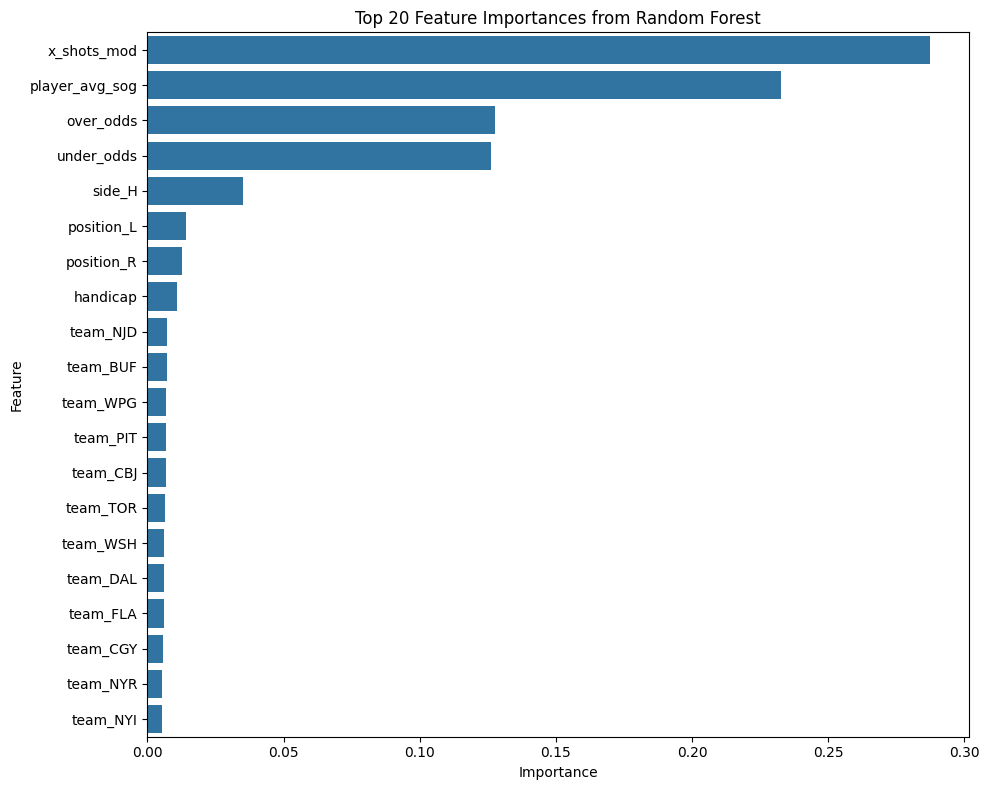

Model saved to models/random_forest_model.pkl
Model loaded successfully.


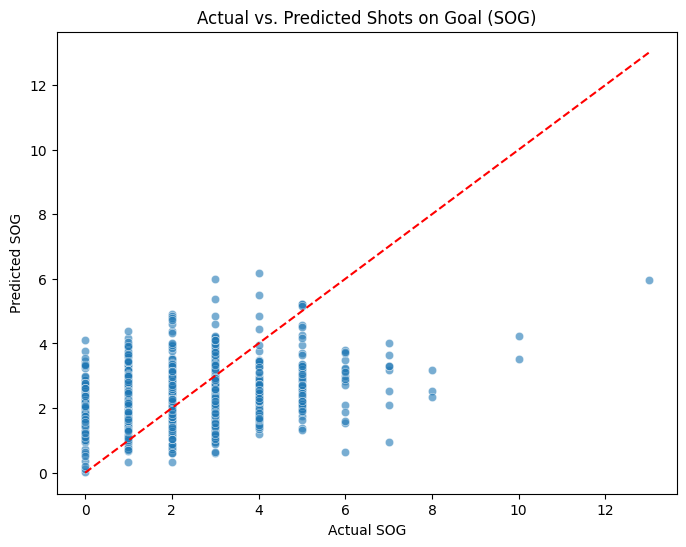

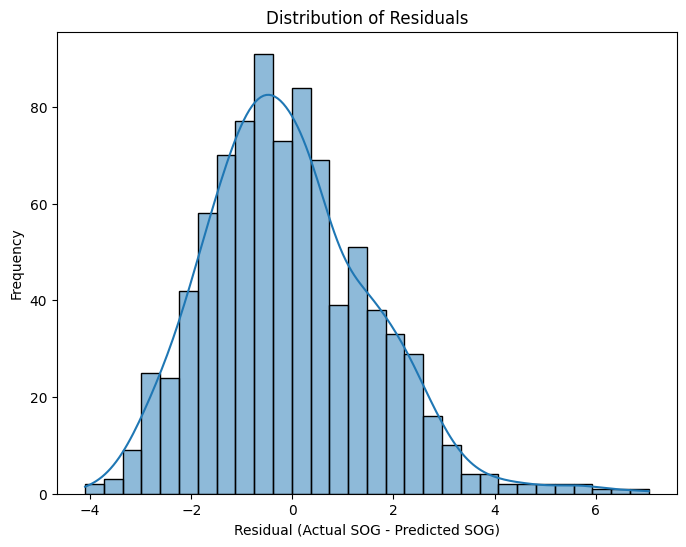

In [44]:
# /Users/jweinga/Documents/python/accurateshothelper/random_forest_model.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load your data
df = combined_shots_df.copy()

# Handle missing values
df = df.dropna(subset=['sog', 'x_shots_mod', 'handicap', 'over_odds', 'under_odds'])

# Feature Engineering: Aggregate player statistics
player_avg_sog = df.groupby('player')['sog'].mean().reset_index()
player_avg_sog.rename(columns={'sog': 'player_avg_sog'}, inplace=True)

# Merge back to the main DataFrame
df = df.merge(player_avg_sog, on='player', how='left')

# Encode categorical variables
categorical_cols = ['team', 'position', 'side']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature Scaling
scaler = StandardScaler()
numerical_cols = ['x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'player_avg_sog']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Define target and features
target = 'sog'
# Remove 'side' from features as it has been one-hot encoded
features = ['x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'player_avg_sog']
# Include all one-hot encoded team and position features
encoded_features = [col for col in df.columns if 'team_' in col or 'position_' in col or 'side_' in col]
features += encoded_features

# Define X and y
X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully.")

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regressor Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature Importance
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

# Save the model
model_filename = 'models/random_forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(rf_model, file)
print(f"Model saved to {model_filename}")

# Load the model (if needed)
with open(model_filename, 'rb') as file:
    loaded_rf_model = pickle.load(file)
print("Model loaded successfully.")

# Visualization of Predictions vs. Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs. Predicted Shots on Goal (SOG)')
plt.xlabel('Actual SOG')
plt.ylabel('Predicted SOG')
plt.show()

# Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual SOG - Predicted SOG)')
plt.ylabel('Frequency')
plt.show()

Random Forest model trained successfully.
Random Forest Regressor Performance:
RMSE: 1.6871
MAE: 1.3137
R² Score: 0.0092
with side and filtering D out
Random Forest model trained successfully.
Random Forest Regressor Performance:
RMSE: 1.6346
MAE: 1.2874
R² Score: 0.0232

In [45]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Update the model with best parameters
rf_model_best = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_best = rf_model_best.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned Random Forest Regressor Performance:")
print(f"RMSE: {rmse_best:.4f}")
print(f"MAE: {mae_best:.4f}")
print(f"R² Score: {r2_best:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Tuned Random Forest Regressor Performance:
RMSE: 1.5516
MAE: 1.2178
R² Score: 0.1199


(with side)
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Tuned Random Forest Regressor Performance:
RMSE: 1.6048
MAE: 1.2503
R² Score: 0.1034
(with side and filtering out D)
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Tuned Random Forest Regressor Performance:
RMSE: 1.5516
MAE: 1.2178
R² Score: 0.1199


In [76]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(
    rf_model,
    X,
    y,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate RMSE for each fold
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE scores: {cv_rmse}")
print(f"Average CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")

Cross-Validation RMSE scores: [1.69779771 1.57996912 1.70697713 1.61129224 1.6553081 ]
Average CV RMSE: 1.6503 (+/- 0.0489)


In [73]:
def simulate_bets(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Simulates bets based on the criteria:
    - If 'x_shots_mod' is within ±threshold of 'handicap', place a 1-unit bet.
    - Determine bet type (Over or Under) based on 'x_shots_mod' relative to 'handicap'.
    - Compare actual 'sog' with 'handicap' to determine the outcome.
    - Tally total wins and losses.

    Args:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            - 'x_shots_mod': Projected shots on goal.
            - 'handicap': The betting line.
            - 'over_odds': American odds for Over.
            - 'under_odds': American odds for Under.
            - 'sog': Actual shots on goal.
        threshold (float, optional): The allowable deviation from the handicap to place a bet. Defaults to 0.5.

    Returns:
        pd.DataFrame: Updated DataFrame with additional columns:
            - 'bet_placed': Boolean indicating if a bet was placed.
            - 'bet_type': 'Over' or 'Under' based on projection.
            - 'bet_odds': Decimal odds of the placed bet.
            - 'bet_outcome': 'Win' or 'Loss'.
            - 'profit_loss': Profit or loss from the bet.
    """

    # Ensure required columns are present
    required_columns = {'x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'sog'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing)}")

    # Initialize columns
    df['bet_placed'] = False
    df['bet_type'] = None
    df['bet_odds'] = None
    df['bet_outcome'] = None
    df['profit_loss'] = 0.0

    # Define the betting criteria based on the parameterized threshold
    mask = (df['x_shots_mod'] - df['handicap']).abs() >= threshold

    # Place bets where criteria are met
    df.loc[mask, 'bet_placed'] = True
    df.loc[mask & (df['x_shots_mod'] > df['handicap']), 'bet_type'] = 'Over'
    df.loc[mask & (df['x_shots_mod'] < df['handicap']), 'bet_type'] = 'Under'

    # Convert American odds to Decimal odds
    df['over_decimal_odds'] = df['over_odds'].apply(american_to_decimal)
    df['under_decimal_odds'] = df['under_odds'].apply(american_to_decimal)

    # Assign corresponding Decimal odds
    df.loc[df['bet_type'] == 'Over', 'bet_odds'] = df['over_decimal_odds']
    df.loc[df['bet_type'] == 'Under', 'bet_odds'] = df['under_decimal_odds']

    # Determine bet outcomes
    # Over Bet Outcomes
    over_win = (df['bet_type'] == 'Over') & (df['sog'] > df['handicap'])
    over_loss = (df['bet_type'] == 'Over') & (df['sog'] <= df['handicap'])

    # Under Bet Outcomes
    under_win = (df['bet_type'] == 'Under') & (df['sog'] < df['handicap'])
    under_loss = (df['bet_type'] == 'Under') & (df['sog'] >= df['handicap'])

    # Assign outcomes
    df.loc[over_win | under_win, 'bet_outcome'] = 'Win'
    df.loc[over_loss | under_loss, 'bet_outcome'] = 'Loss'

    # Calculate profit or loss
    # For Wins: (Decimal Odds - 1) * 1 unit
    df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1

    # For Losses: -1 unit
    df.loc[df['bet_outcome'] == 'Loss', 'profit_loss'] = -1

    return df

# Example usage:
# combined_shots_df = simulate_bets(combined_shots_df, threshold=0.5)
# print(combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed']))

In [74]:
# Example usage:
# combined_shots_df = simulate_bets(combined_shots_df, threshold=0.4)
# combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed'])

shots_010825_df = simulate_bets(combined_shots_df, threshold=0.4)


C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.625 0.6578947368421053 0.5882352941176472 1.2199999999999998 0.625 1.08
 0.6944444444444444 0.819672131147541 0.7407407407407407 1.04
 0.606060606060606 0.6578947368421053 0.5952380952380953 0.78125
 0.5263157894736841 0.5263157894736841 0.5263157894736841
 0.606060606060606 0.6097560975609757 0.625 0.5747126436781609 0.625
 0.606060606060606 0.8771929824561404 0.5747126436781609
 0.5319148936170213 0.7407407407407407 0.6578947368421053 0.625
 0.5617977528089888 0.9090909090909092 0.625 0.7407407407407407
 0.7142857142857144 0.4878048780487805 1.38 0.9433962264150944
 0.6849315068493151 0.8849557522123894 0.6097560975609757
 0.6493506493506493 0.8333333333333335 0.8 0.7692307692307692
 0.7142857142857144 0.625 0.78125 0.5882352941176472 0.5494505494505495
 0.7692307692307692 0.5050505050505

In [81]:
def simulate_bets_directional_thresholds(
    df: pd.DataFrame, 
    threshold_positive: float = 0.5, 
    threshold_negative: float = 0.5
) -> pd.DataFrame:
    """
    Simulates bets based on directional threshold criteria:
    - Place an Over bet if 'x_shots_mod' is >= handicap + threshold_positive.
    - Place an Under bet if 'x_shots_mod' is <= handicap - threshold_negative.
    - Determine bet type based on the projection relative to the handicap.
    - Compare actual 'sog' with 'handicap' to determine the outcome.
    - Tally total wins and losses.

    Args:
        df (pd.DataFrame): DataFrame containing at least the following columns:
            - 'x_shots_mod': Projected shots on goal.
            - 'handicap': The betting line.
            - 'over_odds': American odds for Over.
            - 'under_odds': American odds for Under.
            - 'sog': Actual shots on goal.
        threshold_positive (float, optional): The minimum deviation above the handicap to place an Over bet. Defaults to 0.5.
        threshold_negative (float, optional): The minimum deviation below the handicap to place an Under bet. Defaults to 0.5.

    Returns:
        pd.DataFrame: Updated DataFrame with additional columns:
            - 'bet_placed': Boolean indicating if a bet was placed.
            - 'bet_type': 'Over' or 'Under' based on projection.
            - 'bet_odds': Decimal odds of the placed bet.
            - 'bet_outcome': 'Win' or 'Loss'.
            - 'profit_loss': Profit or loss from the bet.
    """

    # Helper function to convert American odds to Decimal odds

    # Ensure required columns are present
    required_columns = {'x_shots_mod', 'handicap', 'over_odds', 'under_odds', 'sog'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing)}")

    # Initialize columns for betting outcomes
    df['bet_placed'] = False
    df['bet_type'] = None
    df['bet_odds'] = None
    df['bet_outcome'] = None
    df['profit_loss'] = 0.0

    # Define Over and Under betting criteria based on directional thresholds
    over_condition = df['x_shots_mod'] >= (df['handicap'] + threshold_positive)
    under_condition = df['x_shots_mod'] <= (df['handicap'] - threshold_negative)

    # Place Over bets where condition is met
    df.loc[over_condition, 'bet_placed'] = True
    df.loc[over_condition, 'bet_type'] = 'Over'

    # Place Under bets where condition is met
    df.loc[under_condition, 'bet_placed'] = True
    df.loc[under_condition, 'bet_type'] = 'Under'

    # Convert American odds to Decimal odds
    df['over_decimal_odds'] = df['over_odds'].apply(american_to_decimal)
    df['under_decimal_odds'] = df['under_odds'].apply(american_to_decimal)

    # Assign corresponding Decimal odds based on bet type
    df.loc[df['bet_type'] == 'Over', 'bet_odds'] = df['over_decimal_odds']
    df.loc[df['bet_type'] == 'Under', 'bet_odds'] = df['under_decimal_odds']

    # Determine bet outcomes
    # Over Bet Outcomes
    over_win = (df['bet_type'] == 'Over') & (df['sog'] > df['handicap'])
    over_loss = (df['bet_type'] == 'Over') & (df['sog'] <= df['handicap'])

    # Under Bet Outcomes
    under_win = (df['bet_type'] == 'Under') & (df['sog'] < df['handicap'])
    under_loss = (df['bet_type'] == 'Under') & (df['sog'] >= df['handicap'])

    # Assign outcomes based on conditions
    df.loc[over_win | under_win, 'bet_outcome'] = 'Win'
    df.loc[over_loss | under_loss, 'bet_outcome'] = 'Loss'

    # Calculate profit or loss
    # For Wins: (Decimal Odds - 1) * 1 unit
    df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1

    # For Losses: -1 unit
    df.loc[df['bet_outcome'] == 'Loss', 'profit_loss'] = -1

    return df

# Example usage:
# combined_shots_df = simulate_bets_directional_thresholds(
#     combined_shots_df, 
#     threshold_positive=0.6, 
#     threshold_negative=0.4
# )
# print(combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed']))

In [75]:
def summarize_bet_outcomes(shots_df: pd.DataFrame) -> None:
    """
    Summarizes bet outcomes and calculates the total profit or loss.

    Args:
        shots_df (pd.DataFrame): DataFrame containing at least 'bet_outcome' and 'profit_loss' columns.

    Raises:
        KeyError: If required columns are missing from the DataFrame.
    """
    required_columns = {'bet_outcome', 'profit_loss'}
    missing_columns = required_columns - set(shots_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Tally the number of Wins and Losses
    bet_outcomes = shots_df['bet_outcome'].value_counts()
    
    print("Bet Outcomes Tally:")
    print(bet_outcomes)
    
    # Calculate total profit or loss
    total_profit_loss = shots_df['profit_loss'].sum()
    print(f"\nTotal Profit/Loss from Bets: {total_profit_loss:.2f} units")

In [76]:
summarize_bet_outcomes(combined_shots_df)

Bet Outcomes Tally:
bet_outcome
Win     769
Loss    520
Name: count, dtype: int64

Total Profit/Loss from Bets: 0.82 units


In [77]:
combined_shots_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds,bet_placed,bet_type,bet_odds,bet_outcome,profit_loss,over_decimal_odds,under_decimal_odds
0,2024-12-01,Brock Boeser,VAN,R,15,190.27,12.68,6.62,14.82,9.46,4.23,16.57,1.83,2.00,3.0,2.5,126.0,-165.0,True,Under,1.606061,Loss,-1,2.260000,1.606061
1,2024-12-01,Conor Garland,VAN,R,22,310.42,14.11,6.96,14.11,11.21,4.70,18.41,2.14,2.34,1.0,2.5,-138.0,106.0,False,None,None,None,0.0,1.724638,2.060000
2,2024-12-01,Elias Pettersson,VAN,C,22,299.78,13.63,5.20,12.41,8.61,4.54,17.79,1.54,1.69,1.0,2.5,122.0,-160.0,True,Under,1.625,Win,0.625,2.220000,1.625000
3,2024-12-01,Kiefer Sherwood,VAN,L,22,256.92,11.68,8.87,17.05,13.31,3.89,15.24,2.25,2.46,1.0,1.5,-170.0,130.0,True,Over,1.588235,Loss,-1,1.588235,2.300000
4,2024-12-01,Jake DeBrusk,VAN,L,22,284.90,12.95,6.95,13.27,9.69,4.32,16.93,1.96,2.15,4.0,2.5,122.0,-160.0,False,None,None,None,0.0,2.220000,1.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2682,2024-12-31,Ryan Nugent-Hopkins,EDM,C,35,469.42,13.41,5.62,10.23,7.92,4.47,15.87,1.49,1.47,3.0,1.5,-188.0,142.0,False,None,None,None,0.0,1.531915,2.420000
2683,2024-12-31,Connor McDavid,EDM,C,33,559.55,16.96,7.72,13.83,10.83,5.65,20.06,2.58,2.55,2.0,3.5,130.0,-170.0,True,Under,1.588235,Win,0.588235,2.300000,1.588235
2684,2024-12-31,Evan Bouchard,EDM,D,36,676.50,18.79,6.21,15.08,8.51,6.26,22.23,2.30,2.28,3.0,2.5,-146.0,112.0,False,None,None,None,0.0,1.684932,2.120000
2685,2024-12-31,Mattias Ekholm,EDM,D,36,663.18,18.42,6.69,16.29,10.22,6.14,21.80,2.43,2.41,2.0,2.5,130.0,-170.0,False,None,None,None,0.0,2.300000,1.588235


In [78]:
def find_optimal_threshold(df: pd.DataFrame, thresholds: list, plot: bool = True) -> pd.DataFrame:
    """
    Iterates over a list of threshold values, applies the simulate_bets function for each threshold,
    and identifies which threshold generates the highest total profit.

    Args:
        df (pd.DataFrame): The DataFrame containing bet data.
        thresholds (list): A list of threshold values to iterate over.
        plot (bool, optional): Whether to plot the threshold vs profit graph. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing each threshold and its corresponding total profit.
                      Also prints the threshold with the highest profit.
    """
    results = []

    for threshold in thresholds:
        # Create a copy of the DataFrame to avoid modifying the original data
        df_copy = df.copy()
        
        # Apply the simulate_bets function with the current threshold
        df_simulated = simulate_bets(df_copy, threshold=threshold)
        
        # Calculate total profit or loss
        total_profit = df_simulated['profit_loss'].sum()
        
        # Append the result
        results.append({'threshold': threshold, 'total_profit_loss': total_profit})
        
        print(f"Threshold: {threshold} | Total Profit/Loss: {total_profit:.2f} units")

    # Create a summary DataFrame
    results_df = pd.DataFrame(results)
    
    # Identify the threshold with the highest profit
    optimal = results_df.loc[results_df['total_profit_loss'].idxmax()]
    print(f"\nOptimal Threshold: {optimal['threshold']} with Total Profit/Loss: {optimal['total_profit_loss']:.2f} units")
    
    # Plot the results if requested
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(results_df['threshold'], results_df['total_profit_loss'], marker='o')
        plt.title('Threshold vs Total Profit/Loss')
        plt.xlabel('Threshold')
        plt.ylabel('Total Profit/Loss (units)')
        plt.grid(True)
        plt.show()
    
    return results_df

C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06 0.625 0.6578947368421053 ... 1.38 0.5882352941176472
 1.2599999999999998]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.625 0.6578947368421053 0.7692307692307692 ... 0.7142857142857144 1.12
 0.5882352941176472]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\2326756496.py:87: FutureWarning: Setting an item of incompa

Threshold: 0.1 | Total Profit/Loss: -67.57 units
Threshold: 0.2 | Total Profit/Loss: -37.63 units
Threshold: 0.3 | Total Profit/Loss: -8.33 units
Threshold: 0.4 | Total Profit/Loss: 0.82 units
Threshold: 0.5 | Total Profit/Loss: -2.10 units
Threshold: 0.6 | Total Profit/Loss: -3.28 units
Threshold: 0.7 | Total Profit/Loss: -10.80 units
Threshold: 0.8 | Total Profit/Loss: -10.05 units
Threshold: 0.9 | Total Profit/Loss: -5.18 units
Threshold: 1.0 | Total Profit/Loss: -13.02 units
Threshold: 1.1 | Total Profit/Loss: -4.64 units
Threshold: 1.2 | Total Profit/Loss: -0.35 units
Threshold: 1.3 | Total Profit/Loss: -0.84 units
Threshold: 1.4 | Total Profit/Loss: 1.05 units
Threshold: 1.5 | Total Profit/Loss: 0.03 units

Optimal Threshold: 1.4 with Total Profit/Loss: 1.05 units


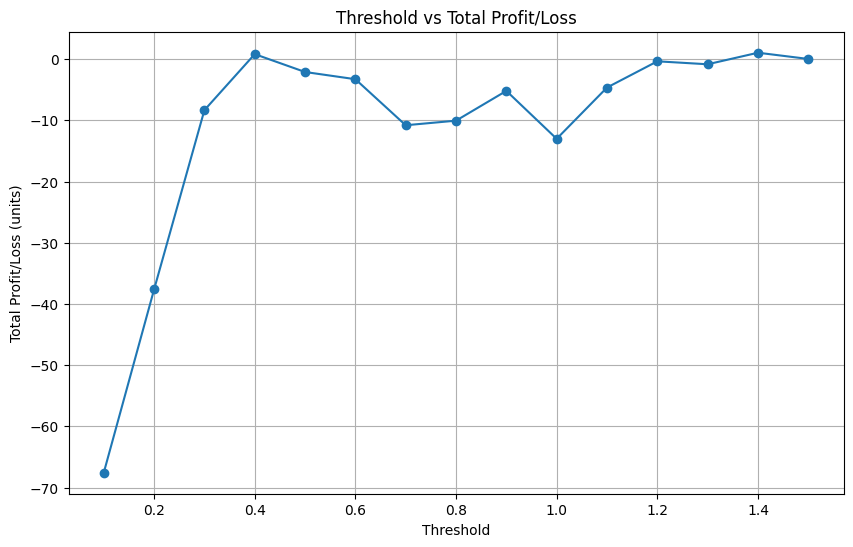


Summary of Threshold Optimization:
    threshold  total_profit_loss
0         0.1         -67.573247
1         0.2         -37.633990
2         0.3          -8.332602
3         0.4           0.820514
4         0.5          -2.098260
5         0.6          -3.276573
6         0.7         -10.798583
7         0.8         -10.049730
8         0.9          -5.183945
9         1.0         -13.016070
10        1.1          -4.637754
11        1.2          -0.351740
12        1.3          -0.835756
13        1.4           1.051390
14        1.5           0.033073


In [79]:
# Define a range of thresholds to test (e.g., 0.1 to 1.5 in increments of 0.1)
threshold_values = [round(x * 0.1, 1) for x in range(1, 16)]  # [0.1, 0.2, ..., 1.5]
# threshold_values = [round(x * 0.1, 1) for x in range(-15, 16)]  # Tests from -1.5 to 1.5 in 0.1 increments
# Apply the find_optimal_threshold function
threshold_results = find_optimal_threshold(combined_shots_df, thresholds=threshold_values, plot=True)

# Display the summary of results
print("\nSummary of Threshold Optimization:")
print(threshold_results)

In [82]:
combined_shots_df = simulate_bets_directional_thresholds(
    combined_shots_df, 
    threshold_positive=0.6, 
    threshold_negative=0.4
)
combined_shots_df[['date', 'player', 'bet_placed', 'bet_type', 'handicap', 'x_shots_mod', 'sog', 'bet_odds', 'bet_outcome', 'profit_loss']].dropna(subset=['bet_placed'])

C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\3061439293.py:97: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.625 0.6578947368421053 1.2199999999999998 0.625 1.08 0.7407407407407407
 1.04 0.606060606060606 0.6578947368421053 0.5952380952380953 0.78125
 0.5263157894736841 0.5263157894736841 0.5263157894736841
 0.606060606060606 0.6097560975609757 0.5747126436781609 0.625
 0.8771929824561404 0.5747126436781609 0.5319148936170213
 0.7407407407407407 0.625 0.5617977528089888 0.9090909090909092 0.625
 0.7407407407407407 0.7142857142857144 1.38 0.9433962264150944
 0.6849315068493151 0.8849557522123894 0.6097560975609757
 0.6493506493506493 0.8333333333333335 0.8 0.7692307692307692
 0.7142857142857144 0.625 0.78125 0.7692307692307692 0.5050505050505052
 0.510204081632653 1.12 1.1799999999999997 0.5208333333333335 1.0
 0.6756756756756757 0.5747126436781609 0.5617977528089888
 0.6578947368421053 0.595238095

,date,player,bet_placed,bet_type,handicap,x_shots_mod,sog,bet_odds,bet_outcome,profit_loss
0,2024-12-01,Brock Boeser,True,Under,2.5,2.00,3.0,1.606061,Loss,-1
1,2024-12-01,Conor Garland,False,None,2.5,2.34,1.0,None,None,0.0
2,2024-12-01,Elias Pettersson,True,Under,2.5,1.69,1.0,1.625,Win,0.625
3,2024-12-01,Kiefer Sherwood,True,Over,1.5,2.46,1.0,1.588235,Loss,-1
4,2024-12-01,Jake DeBrusk,False,None,2.5,2.15,4.0,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...
2682,2024-12-31,Ryan Nugent-Hopkins,False,None,1.5,1.47,3.0,None,None,0.0
2683,2024-12-31,Connor McDavid,True,Under,3.5,2.55,2.0,1.588235,Win,0.588235
2684,2024-12-31,Evan Bouchard,False,None,2.5,2.28,3.0,None,None,0.0
2685,2024-12-31,Mattias Ekholm,False,None,2.5,2.41,2.0,None,None,0.0


C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06 0.625 0.6578947368421053 ... 0.5882352941176472 0.5882352941176472
 1.2599999999999998]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\2326756496.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06 0.625 0.6578947368421053 ... 0.5882352941176472 0.5882352941176472
 1.2599999999999998]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['bet_outcome'] == 'Win', 'profit_loss'] = df['bet_odds'] - 1
C:\Users\H-100\AppData\Local\Temp\ipykernel_3656\2326756496.py:87: FutureWarning: Setting an i

Threshold: -1.5 | Total Profit/Loss: -114.99 units
Threshold: -1.4 | Total Profit/Loss: -114.99 units
Threshold: -1.3 | Total Profit/Loss: -114.99 units
Threshold: -1.2 | Total Profit/Loss: -114.99 units
Threshold: -1.1 | Total Profit/Loss: -114.99 units
Threshold: -1.0 | Total Profit/Loss: -114.99 units
Threshold: -0.9 | Total Profit/Loss: -114.99 units
Threshold: -0.8 | Total Profit/Loss: -114.99 units
Threshold: -0.7 | Total Profit/Loss: -114.99 units
Threshold: -0.6 | Total Profit/Loss: -114.99 units
Threshold: -0.5 | Total Profit/Loss: -114.99 units
Threshold: -0.4 | Total Profit/Loss: -114.99 units
Threshold: -0.3 | Total Profit/Loss: -114.99 units
Threshold: -0.2 | Total Profit/Loss: -114.99 units
Threshold: -0.1 | Total Profit/Loss: -114.99 units
Threshold: 0.0 | Total Profit/Loss: -114.99 units
Threshold: 0.1 | Total Profit/Loss: -67.57 units
Threshold: 0.2 | Total Profit/Loss: -37.63 units
Threshold: 0.3 | Total Profit/Loss: -8.33 units
Threshold: 0.4 | Total Profit/Loss: 0.8

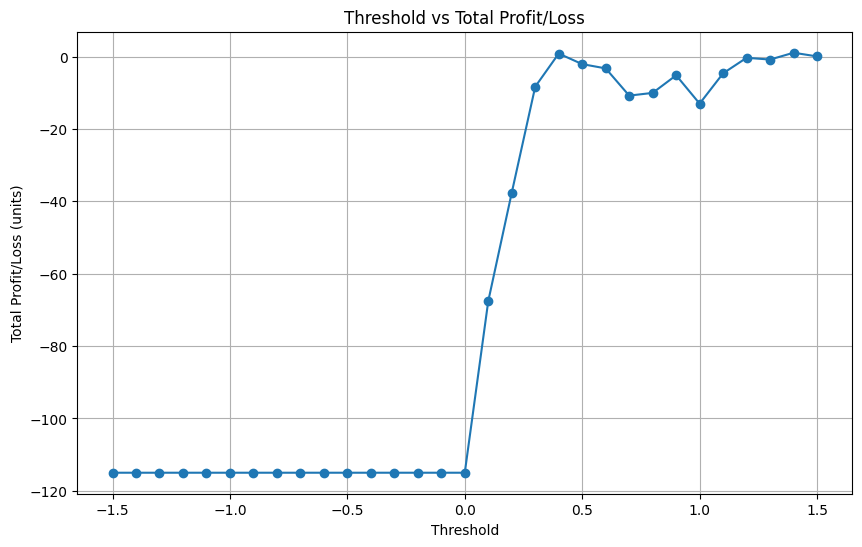


Summary of Threshold Optimization:
    threshold  total_profit_loss
0        -1.5        -114.990599
1        -1.4        -114.990599
2        -1.3        -114.990599
3        -1.2        -114.990599
4        -1.1        -114.990599
5        -1.0        -114.990599
6        -0.9        -114.990599
7        -0.8        -114.990599
8        -0.7        -114.990599
9        -0.6        -114.990599
10       -0.5        -114.990599
11       -0.4        -114.990599
12       -0.3        -114.990599
13       -0.2        -114.990599
14       -0.1        -114.990599
15        0.0        -114.990599
16        0.1         -67.573247
17        0.2         -37.633990
18        0.3          -8.332602
19        0.4           0.820514
20        0.5          -2.098260
21        0.6          -3.276573
22        0.7         -10.798583
23        0.8         -10.049730
24        0.9          -5.183945
25        1.0         -13.016070
26        1.1          -4.637754
27        1.2          -0.351740
28     

In [83]:
# Define a range of thresholds to test (e.g., 0.1 to 1.5 in increments of 0.1)
# threshold_values = [round(x * 0.1, 1) for x in range(1, 16)]  # [0.1, 0.2, ..., 1.5]
threshold_values = [round(x * 0.1, 1) for x in range(-15, 16)]  # Tests from -1.5 to 1.5 in 0.1 increments
# Apply the find_optimal_threshold function
threshold_results = find_optimal_threshold(combined_shots_df, thresholds=threshold_values, plot=True)

# Display the summary of results
print("\nSummary of Threshold Optimization:")
print(threshold_results)

In [84]:
def plot_profit_loss_over_time(df: pd.DataFrame) -> None:
    """
    Plots the cumulative profit/loss over time.

    Args:
        df (pd.DataFrame): DataFrame containing at least 'date' and 'profit_loss' columns.

    Raises:
        KeyError: If 'date' or 'profit_loss' columns are missing.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Check for required columns
    required_columns = {'date', 'profit_loss'}
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")

    # Convert 'date' column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Sort the DataFrame by date
    df_sorted = df.sort_values('date')

    # Calculate cumulative profit/loss
    df_sorted['cumulative_profit_loss'] = df_sorted['profit_loss'].cumsum()

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_sorted, x='date', y='cumulative_profit_loss', marker='o')
    plt.title('Cumulative Profit/Loss Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Profit/Loss (Units)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

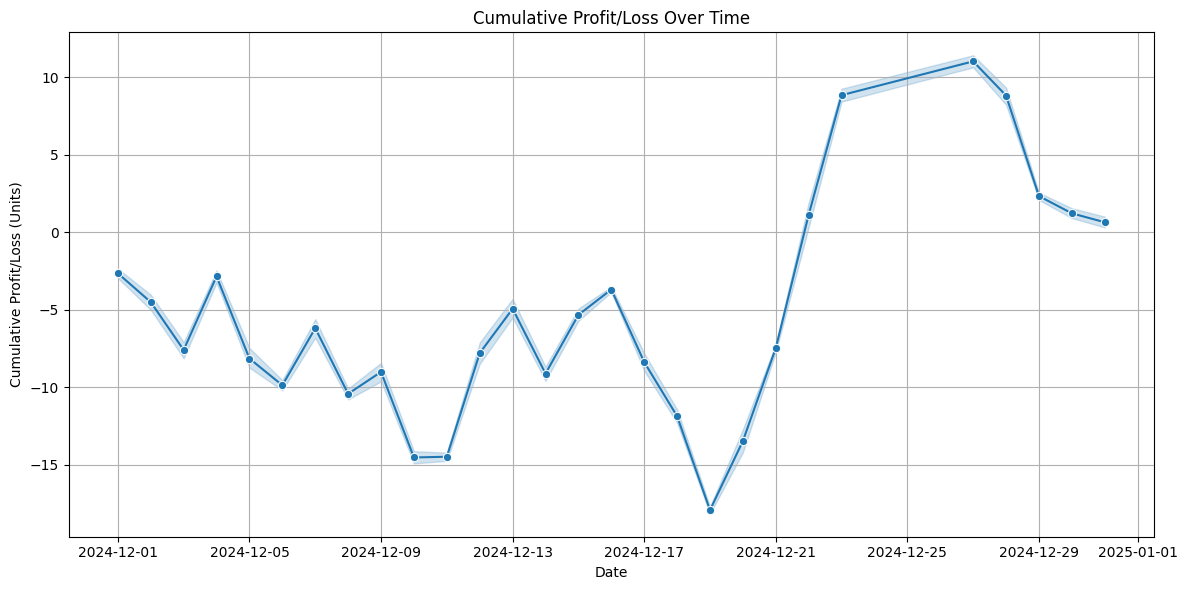

In [85]:
plot_profit_loss_over_time(combined_shots_df)

Root Mean Square Error (RMSE): 1.6645
Mean Absolute Error (MAE): 1.2753
R² Score: 0.0229


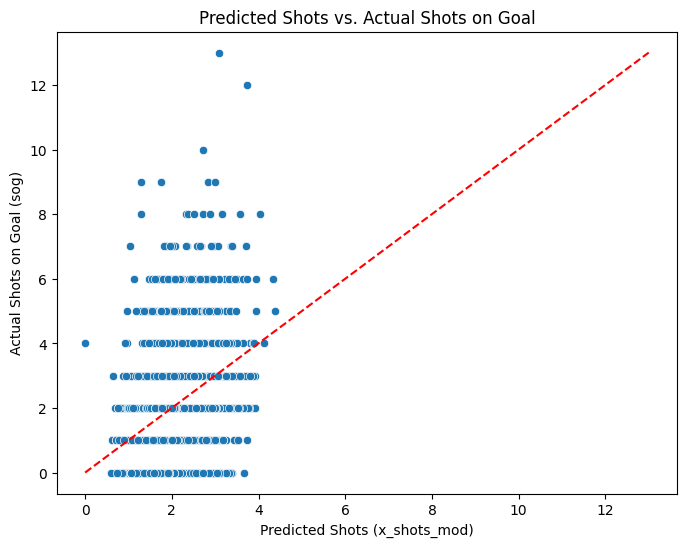

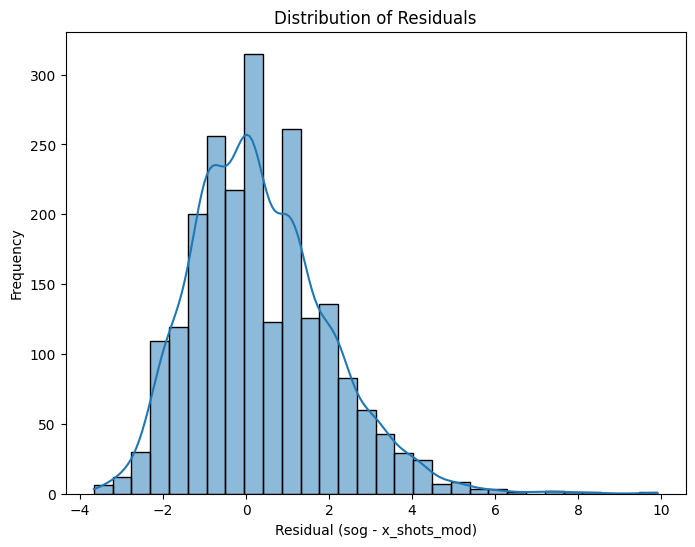

                 player      RMSE
0          Aaron Ekblad  1.429565
1         Adam Fantilli  1.395801
2              Adam Fox  1.172519
3          Adam Larsson  0.050000
4          Adrian Kempe  2.471295
..                  ...       ...
249      Wyatt Johnston  0.794838
250     Yegor Chinakhov  2.100000
251  Yegor Sharangovich  1.454493
252          Zach Hyman  1.014117
253       Zach Werenski  2.295750

[254 rows x 2 columns]


C:\Users\H-100\AppData\Local\Temp\ipykernel_26848\3061046609.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_rmse = data.groupby('player').apply(


In [53]:
from db_utils.prop_odds_db_utils import american_to_decimal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = combined_shots_df.dropna().copy()

# Ensure that the data is a deep copy to avoid SettingWithCopyWarning
data = combined_shots_df.dropna().copy()

# Convert American odds to Decimal odds using .loc
data.loc[:, 'over_decimal_odds'] = data['over_odds'].apply(american_to_decimal)
data.loc[:, 'under_decimal_odds'] = data['under_odds'].apply(american_to_decimal)

# If 'implied_over_prob' and 'implied_under_prob' are no longer needed, you can remove them
# data.loc[:, 'implied_over_prob'] = 1 / data['over_decimal_odds']
# data.loc[:, 'implied_under_prob'] = 1 / data['under_decimal_odds']

# Compare model predictions to actual shots on goal
# Calculate RMSE between model predictions and actual shots on goal
rmse = np.sqrt(mean_squared_error(data['sog'], data['x_shots_mod']))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Calculate MAE for additional insight
mae = mean_absolute_error(data['sog'], data['x_shots_mod'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate R² Score to understand variance explained by the model
r2 = r2_score(data['sog'], data['x_shots_mod'])
print(f"R² Score: {r2:.4f}")

# Optional: Visualize the relationship between predicted and actual shots
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x_shots_mod', y='sog', data=data)
plt.plot([data['sog'].min(), data['sog'].max()], [data['sog'].min(), data['sog'].max()], 'r--')  # Diagonal line
plt.title('Predicted Shots vs. Actual Shots on Goal')
plt.xlabel('Predicted Shots (x_shots_mod)')
plt.ylabel('Actual Shots on Goal (sog)')
plt.show()

# Optional: Residual Analysis
data['residuals'] = data['sog'] - data['x_shots_mod']

plt.figure(figsize=(8, 6))
sns.histplot(data['residuals'], bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (sog - x_shots_mod)')
plt.ylabel('Frequency')
plt.show()

# Optional: Per-Player RMSE
player_rmse = data.groupby('player').apply(
    lambda df: np.sqrt(mean_squared_error(df['sog'], df['x_shots_mod']))
).reset_index(name='RMSE')

print(player_rmse)